# 1. 라이브러리 

In [1]:
# 데이터 처리 라이브러리
import os
import os.path as pth
from tqdm import tqdm
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import cv2
import mediapipe as mp

# Tensorflow 관련 라이브러리
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Sequential,Model, load_model
# from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, BatchNormalization, Flatten, Activation, Dense
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.optimizers import Adam

# GPU 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)


# 2. 데이터 불러오기

## 2-1. 필요한 라벨링만 불러오기

In [2]:
label_df = pd.read_excel('./data/categries_emo.xlsx')
label_dict = dict(label_df[['Num','Emotion']].values)


# 파일 제목에서 3번째 항목만 사용
print(label_df)

emotion_arr = label_df.loc[:,'Num'].values


emotion_list = emotion_arr.tolist()
#print(emotion_list)

label_dict[1]

   Num    Emotion
0    1    neutral
1    2       calm
2    3      happy
3    4        sad
4    5      angry
5    6    fearful
6    7    disgust
7    8  surprised


'neutral'

## 2-2. 경로 불러오기

In [3]:
# 파일의 경로와 라벨정보를 담은 df 생성
path = './data/emotion_data'

files = list()
categories = list()


for img_cat in os.listdir(path):
    cat = path + '/' + img_cat
    
    for filename in os.listdir(cat):
        file_list = cat + '/' + filename
        files.append(file_list)
        
        emo = filename[7]
#        print(emo)
        
        for n in emo:
            categories.append(n)


train_data = pd.DataFrame({'file':files,
                           'label':categories})



        
        

## 2-3. 동영상 프레임 단위로 변환

In [ ]:
# 변환 끝

for file in files:
    vidcap = cv2.VideoCapture(file)
    success,image = vidcap.read()

    count = 1
    success = True
    
    labeled_file = file.split('/')[-1].split('.')[0]
    
    while success:
       
        success,image = vidcap.read()
        if success == False:
            break
        imWrite=cv2.imwrite('./data/emotion_img/%s_%d.jpg' %(labeled_file,count), image)        
        if imWrite==True:
            print("Success Saved Image")
           
        else:
            print("Faile Saved Image")
            
       
        print('%s_%d.jpg' %(labeled_file,count))
        
        if cv2.waitKey(10) == 27:
            break
        count += 1
         
        

# 이미지 몇개인지 테스트 해봄        
        
        
#         if success ==True:
#             #cv2_imshow(image)
#             #break
#             count+=1

# print(count)
    
    

In [4]:
# 추출한 이미지 df 만들기

img_list = list()
img_cate = list()
img_path = './data/emotion_img'



for img in os.listdir(img_path):
    file_path = img_path + '/' + img
    img_list.append(file_path)
    
    emo_img = img[7]
    #print(emo_img)
    
    for n in emo_img:
        img_cate.append(n)

# print(img_cate)    

df_img = pd.DataFrame({'file':img_list,
                       'label':img_cate})
# df_img

In [6]:
label = df_img.loc[:,'label'].values
emotion = list()

# label_dict[3]

for n in label:
    #print(n)
    emotion.append(label_dict[int(n)])

#print(emotion)
    

df_img['emotion'] = emotion
df_img 

file label    emotion
0       ./data/emotion_img/02-01-07-02-01-02-12_98.jpg     7    disgust
1      ./data/emotion_img/02-01-06-01-01-02-12_103.jpg     6    fearful
2       ./data/emotion_img/02-01-08-01-02-02-12_18.jpg     8  surprised
3       ./data/emotion_img/02-01-06-01-01-02-12_69.jpg     6    fearful
4       ./data/emotion_img/02-01-08-01-01-01-12_92.jpg     8  surprised
...                                                ...   ...        ...
94329   ./data/emotion_img/02-01-01-01-01-01-02_11.jpg     1    neutral
94330   ./data/emotion_img/02-01-02-02-02-01-06_89.jpg     2       calm
94331   ./data/emotion_img/02-01-08-02-01-01-21_51.jpg     8  surprised
94332   ./data/emotion_img/02-01-07-02-02-02-20_52.jpg     7    disgust
94333   ./data/emotion_img/02-01-06-01-02-02-02_31.jpg     6    fearful

[94334 rows x 3 columns]

# 3. Face Mesh 

In [ ]:
# cv2.imshow를 대신하는 함수
# 반드시 먼저 실행

def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    return plt.imshow(a, **kwargs)

In [ ]:
# 테스트군(실행 x)
test_list = img_list[0:9]

print(test_list)

labeled_test_list = test_list[1].split('/')[-1].split('.')[0]
labeled_test_list

## 3-1. 랜드마크좌표, 랜드마크 이미지 출력

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh


# 이미지 처리
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True,
                                  max_num_faces=1,
                                  min_detection_confidence=0.5)


drawing_spec = mp_drawing.DrawingSpec(thickness=1, 
                                      circle_radius=1)


# 위에서 만든 jpg 리스트 넣기
for idx, img in enumerate(img_list):
    image = cv2.imread(img)
    image_conv=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_conv)
    
    labeled_list = img.split('/')[-1].split('.')[0]
            
    # 테스트
    if not results.multi_face_landmarks:
        continue
    annotated_image = image.copy()
    
    fileTemp=''
    
    for face_landmarks in results.multi_face_landmarks:
        print('face_landmarks:', face_landmarks)
      
        
        
        fileTemp+=str(face_landmarks)
        
        
        mp_drawing.draw_landmarks(image=annotated_image,
                                  landmark_list=face_landmarks,
                                  connections=mp_face_mesh.FACE_CONNECTIONS,
                                  landmark_drawing_spec=drawing_spec,
                                  connection_drawing_spec=drawing_spec)
    cv2.imwrite('./data/emotion_land/%s.png' %labeled_list, annotated_image)
    with open('./data/emotion_land/%s.txt'%labeled_list,'w') as f:
        f.write(str(fileTemp))
        
face_mesh.close()
        

    
    


In [ ]:
# 시리얼라이즈되는지 확인
# 시리얼라이즈는 되지만 다시 데이터 읽어오는거 실패
# 하지 않는 것으로...

strstr=''
with open('./data/emotion_land/02-01-08-01-02-02-12_18.txt','r') as f:
    strstr=f.read()

bytearr=bytearray(strstr,'utf-8')
print(bytearr)

## 3-2. txt 파일(좌표값) 남기기

In [7]:
# landmark 찍힌 이미지만 지우고 txt파일 남기기

for filename in os.listdir('./data/emotion_land'):
    #print(filename)
    if 'png' in filename:
        os.remove('./data/emotion_land' + '/' + filename)


02-01-04-01-01-02-03_40.txt
02-01-02-02-01-02-02_85.png
02-01-06-01-01-02-05_73.txt
02-01-03-01-02-02-10_23.png
02-01-06-01-01-01-14_97.png
02-01-03-02-02-01-19_45.txt
02-01-02-02-02-01-19_89.png
02-01-02-01-01-02-09_12.png
02-01-04-01-01-01-20_73.png
02-01-03-01-02-01-09_23.png
02-01-01-01-01-02-17_86.txt
02-01-05-02-02-01-10_29.txt
02-01-07-02-01-02-23_46.png
02-01-08-02-02-02-19_74.txt
02-01-03-02-01-02-11_71.txt
02-01-04-01-02-01-24_101.txt
02-01-04-01-02-01-21_14.txt
02-01-05-01-02-02-20_105.txt
02-01-05-01-02-02-05_111.txt
02-01-06-02-01-01-15_85.png
02-01-07-02-02-02-07_1.png
02-01-04-02-02-01-10_6.txt
02-01-07-01-02-02-02_24.txt
02-01-05-01-02-02-22_37.txt
02-01-07-01-01-01-04_13.txt
02-01-02-01-01-02-04_29.txt
02-01-04-02-01-01-21_117.txt
02-01-04-01-01-01-04_52.txt
02-01-02-01-02-01-24_82.txt
02-01-06-01-02-01-07_82.png
02-01-06-01-01-01-24_45.txt
02-01-04-02-02-02-12_87.png
02-01-04-02-01-01-21_89.txt
02-01-05-01-02-01-14_68.png
02-01-02-01-01-01-14_45.png
02-01-02-01-02-02-

02-01-08-01-01-02-04_59.png
02-01-04-02-02-01-15_67.png
02-01-05-01-02-01-16_41.png
02-01-05-02-02-01-18_69.txt
02-01-05-02-02-01-23_60.txt
02-01-02-01-02-02-11_5.png
02-01-03-01-02-02-20_95.txt
02-01-07-01-01-01-03_85.txt
02-01-06-01-01-01-24_99.png
02-01-02-01-01-02-02_14.png
02-01-07-02-02-02-18_77.png
02-01-04-02-01-02-11_43.png
02-01-02-01-02-01-20_44.png
02-01-03-01-01-01-22_31.png
02-01-01-01-01-02-16_94.txt
02-01-01-01-01-01-22_24.png
02-01-05-01-01-01-22_49.png
02-01-06-01-02-01-23_42.txt
02-01-06-02-01-02-17_9.png
02-01-01-01-01-02-08_98.png
02-01-05-01-02-01-13_13.png
02-01-06-02-02-02-05_65.png
02-01-08-01-01-02-05_65.txt
02-01-05-02-01-02-18_23.png
02-01-07-02-01-01-18_32.txt
02-01-02-01-01-02-17_37.png
02-01-08-01-02-01-19_116.txt
02-01-04-01-02-01-13_23.png
02-01-08-01-01-02-20_66.png
02-01-07-02-01-01-06_44.png
02-01-04-02-02-01-04_74.png
02-01-07-01-02-02-04_89.txt
02-01-08-02-01-02-21_56.txt
02-01-06-01-01-02-22_20.txt
02-01-05-01-01-02-14_40.png
02-01-03-01-02-01-12_

02-01-08-02-01-01-22_93.png
02-01-01-01-02-02-19_64.png
02-01-08-02-01-02-24_23.png
02-01-03-01-02-01-05_4.png
02-01-08-02-02-01-15_24.png
02-01-01-01-01-01-05_52.png
02-01-03-01-02-02-20_10.txt
02-01-04-02-02-02-20_87.txt
02-01-07-02-01-01-14_40.png
02-01-06-02-01-01-23_34.txt
02-01-01-01-02-02-11_28.png
02-01-07-02-01-01-06_57.png
02-01-03-02-02-02-11_75.png
02-01-01-01-02-02-07_9.txt
02-01-08-02-01-02-22_79.txt
02-01-01-01-02-01-23_103.txt
02-01-08-01-01-01-17_86.txt
02-01-03-02-02-01-13_90.png
02-01-08-01-02-02-10_100.png
02-01-04-02-02-01-17_100.png
02-01-07-02-02-02-01_32.txt
02-01-04-02-02-01-04_58.txt
02-01-05-02-01-02-08_99.png
02-01-08-02-01-01-08_59.txt
02-01-02-02-01-01-05_68.txt
02-01-03-01-01-02-01_56.txt
02-01-06-01-02-01-24_114.png
02-01-05-02-01-02-11_101.txt
02-01-04-01-01-02-17_45.png
02-01-07-02-02-02-05_62.txt
02-01-05-02-01-01-13_70.png
02-01-01-01-01-01-23_65.png
02-01-01-01-02-01-05_34.txt
02-01-06-02-02-01-02_1.txt
02-01-06-01-02-02-09_26.txt
02-01-03-02-01-01-

02-01-05-02-02-01-11_101.png
02-01-03-01-01-01-05_100.png
02-01-03-01-01-01-21_104.txt
02-01-05-01-02-01-06_107.png
02-01-03-02-01-01-08_9.png
02-01-07-01-02-01-07_1.png
02-01-05-02-01-01-15_91.png
02-01-08-02-02-01-15_22.png
02-01-02-01-02-02-11_23.png
02-01-03-02-02-02-13_24.png
02-01-05-01-01-02-20_30.txt
02-01-07-01-01-02-06_57.png
02-01-04-01-02-01-14_46.txt
02-01-03-01-01-02-22_39.txt
02-01-04-01-01-01-12_92.txt
02-01-07-01-02-01-21_5.txt
02-01-05-02-01-02-04_52.png
02-01-08-02-01-01-10_85.txt
02-01-06-01-02-02-15_44.txt
02-01-01-01-01-01-07_71.png
02-01-06-01-01-02-18_45.txt
02-01-04-02-02-01-06_63.png
02-01-08-01-02-02-10_73.png
02-01-08-01-02-01-06_76.png
02-01-02-01-02-01-13_79.png
02-01-06-02-02-02-20_16.txt
02-01-08-01-01-01-02_67.png
02-01-02-02-02-02-08_26.png
02-01-03-01-01-02-15_43.png
02-01-05-02-01-02-07_38.png
02-01-06-01-01-02-15_64.png
02-01-02-02-02-02-07_81.png
02-01-07-02-01-01-19_19.png
02-01-05-01-01-01-03_54.png
02-01-04-01-02-02-15_44.txt
02-01-03-02-02-02-1

02-01-03-02-01-01-04_47.png
02-01-08-01-01-02-19_54.txt
02-01-03-02-01-01-12_63.png
02-01-06-01-01-01-16_81.png
02-01-03-02-01-01-19_67.png
02-01-05-01-02-02-10_103.txt
02-01-05-02-01-02-08_26.png
02-01-03-01-01-02-04_56.png
02-01-07-02-01-01-04_2.png
02-01-06-01-01-01-19_65.png
02-01-07-01-02-02-06_8.txt
02-01-07-02-02-02-23_92.png
02-01-03-01-02-02-09_98.txt
02-01-07-01-01-02-19_81.txt
02-01-03-01-01-01-14_40.png
02-01-05-01-02-02-16_14.txt
02-01-01-01-02-02-10_39.png
02-01-02-02-02-02-20_48.txt
02-01-08-02-02-01-14_109.png
02-01-06-01-01-02-10_36.txt
02-01-03-02-02-01-01_110.txt
02-01-05-01-01-01-20_88.txt
02-01-08-01-02-01-07_9.png
02-01-05-01-02-01-07_53.png
02-01-06-02-01-02-11_30.png
02-01-07-02-01-01-14_10.txt
02-01-05-02-01-01-22_72.png
02-01-08-01-02-02-05_56.png
02-01-04-02-01-01-08_4.txt
02-01-05-02-02-02-16_114.txt
02-01-06-01-01-01-20_10.png
02-01-02-01-01-02-03_30.txt
02-01-06-02-01-02-06_3.txt
02-01-02-02-01-01-23_88.txt
02-01-07-02-01-01-24_125.txt
02-01-06-01-01-02-17

02-01-01-01-02-01-13_85.png
02-01-03-01-02-02-09_41.png
02-01-06-01-01-01-17_96.png
02-01-05-01-02-01-19_35.txt
02-01-03-01-01-01-19_43.txt
02-01-08-02-02-02-06_93.png
02-01-04-01-02-01-20_18.png
02-01-04-01-02-01-18_72.png
02-01-05-01-02-02-09_36.png
02-01-03-01-02-02-24_99.txt
02-01-07-01-01-01-10_70.txt
02-01-04-01-01-01-09_11.png
02-01-03-01-01-01-12_67.txt
02-01-07-01-01-01-06_21.png
02-01-05-01-01-02-01_51.txt
02-01-02-02-01-02-17_34.png
02-01-08-02-02-02-01_20.png
02-01-08-01-01-02-02_82.txt
02-01-02-01-01-01-14_100.png
02-01-08-01-02-01-16_75.txt
02-01-06-02-02-02-05_33.png
02-01-03-01-02-01-15_41.txt
02-01-03-01-02-01-20_64.png
02-01-04-02-01-01-15_14.txt
02-01-02-02-02-02-05_52.txt
02-01-07-02-02-01-22_64.png
02-01-08-02-01-01-05_78.png
02-01-03-02-01-02-08_81.txt
02-01-06-01-02-02-15_10.txt
02-01-03-01-01-01-08_71.png
02-01-04-01-02-01-09_71.png
02-01-07-01-01-01-09_40.txt
02-01-03-01-01-01-07_24.png
02-01-06-02-02-01-11_45.png
02-01-07-01-02-01-11_9.png
02-01-03-02-01-01-11

02-01-01-01-02-01-18_7.png
02-01-07-02-01-01-10_23.txt
02-01-03-02-01-01-18_9.png
02-01-04-02-02-01-10_33.png
02-01-05-01-01-02-19_75.png
02-01-06-01-02-02-12_48.txt
02-01-03-02-01-01-15_82.txt
02-01-07-02-01-02-23_47.png
02-01-02-01-02-01-16_111.png
02-01-07-02-02-02-01_95.txt
02-01-04-01-01-02-23_97.png
02-01-02-01-02-02-07_92.png
02-01-05-01-01-02-16_32.png
02-01-02-01-02-01-22_47.txt
02-01-05-01-02-01-18_16.txt
02-01-05-02-02-01-13_49.txt
02-01-03-01-01-01-21_47.txt
02-01-03-02-02-01-24_92.png
02-01-02-01-01-01-24_80.txt
02-01-07-02-02-02-08_81.png
02-01-03-01-02-02-08_61.png
02-01-06-01-02-02-02_9.txt
02-01-08-01-02-01-05_4.png
02-01-06-02-01-02-20_113.png
02-01-02-02-01-02-03_17.txt
02-01-05-01-02-01-21_71.txt
02-01-02-01-02-01-18_17.png
02-01-03-02-02-01-01_45.txt
02-01-05-02-02-01-03_121.txt
02-01-01-01-01-02-08_56.png
02-01-06-01-02-01-02_45.png
02-01-03-01-02-01-19_25.png
02-01-08-01-02-02-02_54.txt
02-01-08-02-02-01-11_14.png
02-01-07-02-01-01-18_78.png
02-01-02-02-01-01-14_

02-01-07-02-02-02-16_50.png
02-01-06-02-01-01-13_50.txt
02-01-03-01-02-01-20_49.txt
02-01-03-01-01-01-17_55.txt
02-01-04-02-01-01-22_20.png
02-01-04-01-01-02-03_12.png
02-01-01-01-01-01-03_95.png
02-01-01-01-01-01-03_15.txt
02-01-07-01-01-02-17_54.png
02-01-05-01-01-01-21_40.png
02-01-08-01-01-01-09_18.txt
02-01-02-02-02-02-01_91.txt
02-01-05-01-02-01-04_34.png
02-01-07-02-02-01-20_111.png
02-01-02-02-01-02-15_22.png
02-01-03-01-01-02-15_59.png
02-01-03-02-01-02-22_37.txt
02-01-02-01-02-01-12_97.txt
02-01-03-01-01-02-02_59.txt
02-01-02-01-02-01-12_95.png
02-01-08-01-02-02-24_82.txt
02-01-08-01-01-02-14_14.png
02-01-03-02-01-02-22_45.txt
02-01-02-01-01-01-05_60.png
02-01-01-01-01-02-16_60.txt
02-01-02-02-02-01-24_48.txt
02-01-06-01-01-02-12_101.png
02-01-06-02-01-01-08_106.png
02-01-04-01-02-02-07_94.png
02-01-05-02-02-02-05_93.png
02-01-04-01-01-02-21_14.txt
02-01-04-02-02-01-03_12.txt
02-01-02-02-02-02-19_124.png
02-01-08-02-01-01-23_47.png
02-01-08-01-01-01-19_30.png
02-01-05-02-01-0

02-01-07-02-01-01-02_47.png
02-01-04-02-02-02-02_99.txt
02-01-05-01-01-02-08_100.txt
02-01-08-01-01-01-19_7.txt
02-01-07-01-02-02-03_86.txt
02-01-03-01-01-01-18_24.png
02-01-08-02-01-01-12_107.png
02-01-08-01-01-02-22_92.txt
02-01-06-02-01-02-11_2.txt
02-01-03-02-01-01-13_5.png
02-01-05-02-02-01-03_90.png
02-01-04-02-01-01-05_77.txt
02-01-02-02-02-01-17_80.txt
02-01-02-01-01-02-07_2.txt
02-01-07-02-01-02-16_20.txt
02-01-07-01-02-02-15_117.txt
02-01-08-01-02-02-19_63.txt
02-01-08-02-02-01-01_53.txt
02-01-03-02-02-01-23_64.txt
02-01-01-01-01-02-02_22.txt
02-01-02-02-01-01-10_82.txt
02-01-06-01-01-01-22_72.txt
02-01-08-01-01-01-01_63.png
02-01-04-01-01-02-06_19.txt
02-01-05-01-02-01-23_5.txt
02-01-02-01-01-02-24_66.txt
02-01-06-01-01-01-06_67.png
02-01-03-01-01-02-01_16.txt
02-01-07-01-01-02-23_79.txt
02-01-07-01-02-02-14_41.txt
02-01-07-01-01-02-16_38.txt
02-01-03-01-01-01-18_11.png
02-01-05-02-01-01-18_102.txt
02-01-04-01-02-01-15_33.txt
02-01-06-02-01-01-02_34.png
02-01-07-02-01-02-19_

02-01-06-01-01-02-02_9.png
02-01-08-02-02-01-02_107.txt
02-01-07-01-01-02-22_86.png
02-01-05-01-01-01-10_66.txt
02-01-04-02-01-02-10_65.png
02-01-06-01-01-02-21_86.png
02-01-01-01-01-01-08_60.png
02-01-01-01-01-02-02_15.png
02-01-04-02-01-01-04_3.png
02-01-05-02-01-01-08_65.png
02-01-05-02-02-02-04_63.txt
02-01-02-02-02-01-15_2.png
02-01-04-02-02-02-04_65.png
02-01-04-02-01-01-14_89.txt
02-01-06-02-01-01-19_1.png
02-01-06-02-01-02-14_68.png
02-01-01-01-02-02-16_67.txt
02-01-04-02-02-02-15_54.png
02-01-04-02-02-02-23_107.txt
02-01-05-02-01-01-01_36.png
02-01-07-01-02-01-13_42.txt
02-01-05-01-01-02-09_61.txt
02-01-08-01-02-02-11_48.txt
02-01-06-02-02-02-05_74.txt
02-01-07-01-01-02-09_50.txt
02-01-05-02-02-01-22_123.txt
02-01-02-01-01-01-24_30.txt
02-01-05-01-02-01-19_42.png
02-01-04-01-02-01-19_82.png
02-01-07-02-01-01-17_74.png
02-01-08-01-01-01-20_85.png
02-01-03-02-01-02-24_84.txt
02-01-06-01-01-01-06_11.png
02-01-05-02-01-01-20_40.png
02-01-03-01-02-01-12_77.txt
02-01-06-01-02-02-08_

02-01-03-01-02-02-13_61.png
02-01-04-01-01-01-10_66.txt
02-01-08-01-02-02-07_16.png
02-01-05-01-01-02-12_12.txt
02-01-04-02-02-01-08_44.txt
02-01-04-01-01-02-15_33.png
02-01-01-01-01-02-21_81.png
02-01-07-01-01-02-15_28.txt
02-01-02-01-01-02-09_95.txt
02-01-07-01-01-01-21_26.png
02-01-08-01-01-02-23_77.png
02-01-05-02-01-01-23_62.png
02-01-06-01-01-01-10_97.png
02-01-08-02-02-01-23_34.png
02-01-02-01-01-02-19_38.txt
02-01-06-02-02-01-16_49.png
02-01-07-02-01-02-10_127.png
02-01-07-02-01-02-19_146.txt
02-01-02-01-01-01-19_31.txt
02-01-02-02-02-02-19_73.txt
02-01-04-01-01-02-23_36.png
02-01-06-02-02-01-16_21.png
02-01-04-02-02-01-24_99.txt
02-01-04-02-02-01-12_102.png
02-01-07-02-01-02-17_31.txt
02-01-05-02-02-02-23_77.png
02-01-08-02-02-01-20_6.png
02-01-08-02-02-01-17_54.png
02-01-05-01-01-02-02_94.png
02-01-08-02-01-01-20_75.txt
02-01-01-01-01-01-16_104.txt
02-01-04-02-02-01-24_44.png
02-01-07-02-02-02-12_56.txt
02-01-08-02-02-01-18_49.png
02-01-03-02-01-01-05_116.txt
02-01-04-02-02-0

02-01-06-02-02-02-12_42.png
02-01-03-01-01-02-04_36.txt
02-01-04-02-02-02-18_8.txt
02-01-03-01-02-02-24_1.png
02-01-05-02-02-02-08_17.png
02-01-07-02-02-01-12_17.txt
02-01-06-01-01-02-23_46.txt
02-01-03-01-02-01-21_60.png
02-01-04-01-01-02-20_33.png
02-01-06-02-02-02-16_40.png
02-01-08-02-01-02-10_27.txt
02-01-08-01-02-02-08_84.png
02-01-03-02-01-01-05_119.png
02-01-04-02-02-01-23_71.png
02-01-04-02-02-01-01_5.png
02-01-04-01-01-01-09_11.txt
02-01-06-02-01-02-24_31.png
02-01-05-01-02-02-07_96.txt
02-01-03-02-02-01-06_81.png
02-01-04-01-02-02-06_56.png
02-01-03-01-01-01-17_64.txt
02-01-01-01-02-02-21_21.png
02-01-03-02-01-01-19_56.png
02-01-08-02-01-02-14_61.png
02-01-02-01-01-02-05_92.png
02-01-04-01-01-02-15_73.txt
02-01-02-01-01-01-02_42.txt
02-01-03-02-01-01-07_104.txt
02-01-07-01-01-02-19_131.png
02-01-04-02-01-02-11_32.png
02-01-06-01-01-01-09_18.png
02-01-02-02-01-02-15_100.txt
02-01-08-01-02-02-19_43.txt
02-01-02-02-02-01-12_27.txt
02-01-05-02-01-02-22_40.txt
02-01-02-01-02-02-0

02-01-06-02-01-01-06_5.png
02-01-08-02-02-02-19_60.png
02-01-04-02-01-02-09_23.txt
02-01-02-01-01-01-20_45.txt
02-01-06-02-02-02-20_116.txt
02-01-08-02-01-02-02_98.txt
02-01-01-01-01-01-13_27.txt
02-01-06-01-02-01-24_61.txt
02-01-08-02-01-01-03_37.png
02-01-08-02-02-01-16_68.png
02-01-05-02-01-01-14_109.txt
02-01-06-01-01-01-18_27.txt
02-01-03-02-01-02-20_58.txt
02-01-04-01-02-02-09_93.png
02-01-04-01-02-02-12_62.png
02-01-04-01-02-01-11_71.txt
02-01-04-01-02-01-13_69.txt
02-01-03-02-02-02-07_66.txt
02-01-08-01-01-02-07_55.txt
02-01-06-01-01-01-16_43.png
02-01-05-01-02-01-24_16.txt
02-01-05-01-02-02-19_30.txt
02-01-05-02-02-02-24_129.png
02-01-03-01-01-02-12_9.png
02-01-06-01-01-01-14_15.txt
02-01-05-02-01-01-04_31.png
02-01-08-01-02-01-13_9.txt
02-01-08-02-02-01-08_34.png
02-01-03-01-01-02-21_93.png
02-01-08-02-02-02-12_98.txt
02-01-04-02-02-02-18_33.png
02-01-08-02-02-02-13_59.txt
02-01-05-01-01-01-04_65.txt
02-01-08-02-01-02-17_19.png
02-01-03-02-02-01-07_69.txt
02-01-05-02-02-02-10

02-01-02-02-02-02-04_58.png
02-01-08-02-02-02-01_79.txt
02-01-07-01-01-01-23_71.txt
02-01-04-01-01-02-07_98.txt
02-01-08-02-01-01-19_38.png
02-01-07-02-02-01-11_5.txt
02-01-01-01-02-02-11_87.txt
02-01-06-02-02-01-14_55.txt
02-01-03-02-01-01-02_17.txt
02-01-02-01-02-02-17_20.txt
02-01-06-01-01-01-01_102.txt
02-01-05-02-02-01-11_51.png
02-01-02-01-02-02-16_86.png
02-01-07-01-01-02-19_93.txt
02-01-03-01-01-02-21_64.txt
02-01-03-02-01-02-20_38.txt
02-01-07-01-01-01-15_24.txt
02-01-02-01-02-02-13_51.txt
02-01-02-01-01-01-15_3.txt
02-01-02-01-02-01-23_58.png
02-01-01-01-01-01-05_26.png
02-01-04-01-01-02-21_71.txt
02-01-03-02-01-01-23_93.png
02-01-02-02-02-02-04_114.txt
02-01-08-01-02-02-01_51.png
02-01-03-01-02-02-14_86.txt
02-01-05-02-01-01-17_1.txt
02-01-08-02-02-01-24_14.txt
02-01-07-02-01-02-18_10.txt
02-01-04-02-01-01-24_113.png
02-01-05-01-01-02-17_72.txt
02-01-05-01-02-01-18_94.txt
02-01-05-02-01-01-23_87.txt
02-01-08-01-01-01-20_19.txt
02-01-08-02-02-01-06_58.png
02-01-04-01-02-01-18

02-01-08-02-01-01-12_37.png
02-01-06-01-02-01-07_35.txt
02-01-07-01-01-02-13_75.png
02-01-07-01-02-02-09_84.txt
02-01-03-01-02-01-05_61.png
02-01-07-02-01-01-06_60.txt
02-01-06-02-02-01-15_64.png
02-01-08-01-01-02-10_73.png
02-01-07-02-01-01-22_113.txt
02-01-02-02-01-01-10_40.txt
02-01-04-01-01-01-09_10.png
02-01-06-02-02-01-18_7.png
02-01-07-02-01-01-10_46.png
02-01-05-02-02-01-07_99.txt
02-01-02-02-02-02-02_24.png
02-01-03-01-02-01-17_77.txt
02-01-08-02-01-02-04_40.txt
02-01-08-02-01-01-04_99.png
02-01-05-01-01-01-02_61.txt
02-01-03-01-02-02-13_62.txt
02-01-08-02-01-01-18_97.txt
02-01-04-02-01-01-06_56.png
02-01-06-02-02-02-22_44.txt
02-01-02-01-02-01-21_35.png
02-01-02-01-02-01-08_28.txt
02-01-04-02-01-01-15_77.png
02-01-05-01-01-02-12_71.png
02-01-08-01-02-01-12_89.txt
02-01-06-02-01-01-08_76.png
02-01-07-02-01-01-05_113.txt
02-01-05-02-02-02-13_8.txt
02-01-06-01-02-01-23_5.txt
02-01-03-02-02-01-13_20.png
02-01-06-02-01-01-13_26.png
02-01-05-02-01-02-21_111.png
02-01-04-02-02-01-21

02-01-03-02-02-01-19_72.png
02-01-02-01-01-02-23_72.png
02-01-02-02-01-02-11_78.png
02-01-04-01-01-01-24_27.png
02-01-05-02-02-01-20_63.png
02-01-04-02-02-02-22_70.png
02-01-06-01-01-01-12_16.png
02-01-01-01-02-01-22_100.txt
02-01-03-02-01-01-08_72.png
02-01-03-02-02-02-08_15.png
02-01-07-02-02-01-15_51.txt
02-01-04-01-01-01-14_71.txt
02-01-07-02-02-01-24_14.png
02-01-02-02-01-02-03_1.txt
02-01-05-01-02-02-08_22.txt
02-01-06-01-01-02-02_10.txt
02-01-08-02-02-02-15_37.png
02-01-04-02-02-01-03_57.txt
02-01-03-01-01-01-13_40.txt
02-01-08-01-01-02-07_60.txt
02-01-02-01-01-02-08_2.png
02-01-05-01-01-02-21_3.png
02-01-02-01-01-02-11_5.txt
02-01-03-02-02-01-13_42.png
02-01-03-02-02-02-02_76.png
02-01-02-01-01-02-02_34.txt
02-01-03-01-01-02-01_72.txt
02-01-06-02-01-02-18_24.txt
02-01-03-02-02-02-14_38.png
02-01-02-02-01-02-24_38.txt
02-01-03-01-01-01-15_29.png
02-01-07-01-02-01-11_93.png
02-01-07-02-02-02-08_3.png
02-01-02-01-02-02-20_61.txt
02-01-07-01-01-01-24_18.txt
02-01-02-02-02-01-24_73.

02-01-06-01-02-02-11_20.png
02-01-05-01-02-02-05_61.png
02-01-03-01-01-02-01_49.txt
02-01-03-02-02-02-14_39.txt
02-01-02-01-01-01-04_40.txt
02-01-07-02-02-02-12_94.txt
02-01-06-01-02-01-16_27.png
02-01-02-02-02-02-10_76.txt
02-01-07-02-02-02-23_33.txt
02-01-04-01-02-02-02_93.png
02-01-04-01-01-02-16_39.txt
02-01-03-02-01-01-16_1.png
02-01-08-02-01-02-06_45.png
02-01-06-02-01-01-09_9.png
02-01-02-02-01-01-22_88.png
02-01-04-01-01-01-15_30.png
02-01-06-02-01-01-01_8.txt
02-01-05-01-01-01-16_13.txt
02-01-03-01-01-02-22_50.txt
02-01-07-01-01-01-12_82.png
02-01-03-02-02-02-15_53.png
02-01-08-02-01-02-22_65.png
02-01-07-02-01-01-18_71.txt
02-01-01-01-02-02-12_81.png
02-01-08-01-01-01-21_25.txt
02-01-08-02-02-01-24_108.txt
02-01-05-01-02-01-15_97.png
02-01-04-01-01-02-14_102.png
02-01-04-02-01-01-18_92.png
02-01-04-02-02-01-17_38.png
02-01-02-02-02-02-23_45.png
02-01-06-02-01-02-07_100.txt
02-01-03-01-01-02-10_75.txt
02-01-05-02-02-01-15_65.txt
02-01-04-01-01-01-11_94.txt
02-01-02-02-02-02-14

02-01-05-02-01-02-22_98.png
02-01-07-02-02-02-05_53.png
02-01-06-02-02-02-07_50.txt
02-01-05-02-02-02-22_22.txt
02-01-07-02-01-02-12_24.txt
02-01-07-01-02-02-15_40.png
02-01-08-02-01-01-11_59.txt
02-01-08-01-01-02-07_47.png
02-01-05-01-02-01-17_101.txt
02-01-01-01-01-02-23_37.png
02-01-05-02-01-02-07_78.png
02-01-07-02-01-01-13_32.png
02-01-05-02-02-01-22_89.txt
02-01-04-01-02-02-15_96.png
02-01-08-02-01-01-12_29.txt
02-01-02-01-01-01-02_84.png
02-01-08-02-01-02-07_107.png
02-01-01-01-02-01-06_47.png
02-01-08-02-01-01-19_83.png
02-01-07-02-02-01-20_102.txt
02-01-07-02-02-02-05_1.txt
02-01-04-02-02-01-08_34.txt
02-01-05-02-02-01-19_98.txt
02-01-03-02-01-02-03_124.txt
02-01-05-02-01-01-18_65.txt
02-01-02-01-01-02-01_50.txt
02-01-07-01-02-01-09_16.txt
02-01-05-02-01-01-07_6.png
02-01-06-02-02-01-24_67.txt
02-01-03-02-01-02-12_17.txt
02-01-05-02-01-01-15_82.txt
02-01-02-01-02-02-09_48.png
02-01-07-02-02-02-06_114.png
02-01-05-01-02-01-24_67.txt
02-01-06-01-02-01-08_53.txt
02-01-06-01-02-02

02-01-04-01-01-02-24_98.png
02-01-08-01-02-02-07_31.txt
02-01-05-02-02-01-17_103.txt
02-01-05-01-02-01-14_41.txt
02-01-06-02-01-02-15_82.txt
02-01-07-01-02-02-12_102.png
02-01-08-01-01-02-14_65.txt
02-01-04-02-01-02-10_70.png
02-01-04-01-02-02-16_8.png
02-01-01-01-02-01-09_63.png
02-01-05-01-02-01-18_10.png
02-01-02-02-01-02-13_57.png
02-01-05-02-02-02-12_24.png
02-01-04-02-01-02-21_49.txt
02-01-02-02-02-02-15_39.png
02-01-05-02-02-02-20_57.txt
02-01-08-02-02-01-02_82.txt
02-01-05-01-01-01-14_34.png
02-01-07-02-02-02-02_93.txt
02-01-06-02-02-02-07_22.png
02-01-04-02-02-01-16_92.png
02-01-04-01-02-02-07_38.txt
02-01-05-01-02-01-04_79.png
02-01-02-02-02-01-21_28.txt
02-01-08-01-01-02-24_11.txt
02-01-06-02-02-02-06_11.txt
02-01-08-01-02-02-10_51.png
02-01-07-01-01-01-12_92.txt
02-01-05-02-01-02-13_108.txt
02-01-03-01-01-01-11_68.txt
02-01-03-02-01-01-14_92.png
02-01-07-01-01-01-11_9.txt
02-01-05-01-01-02-07_53.png
02-01-03-02-01-02-23_28.png
02-01-08-01-02-01-03_90.txt
02-01-07-02-02-02-1

02-01-02-01-02-02-11_105.png
02-01-04-02-01-01-10_16.txt
02-01-04-01-02-02-02_84.png
02-01-04-01-02-02-17_66.png
02-01-06-02-02-02-08_50.png
02-01-08-01-01-02-10_29.png
02-01-02-01-02-02-05_38.png
02-01-04-01-02-01-17_60.png
02-01-07-01-02-01-02_33.txt
02-01-03-02-02-01-24_1.txt
02-01-07-01-02-01-22_100.txt
02-01-06-02-02-02-14_58.txt
02-01-01-01-02-01-09_46.txt
02-01-07-01-02-02-14_25.txt
02-01-05-02-02-01-24_102.txt
02-01-02-01-01-01-19_23.txt
02-01-08-02-02-01-17_80.txt
02-01-06-01-02-02-15_32.txt
02-01-03-01-01-01-15_68.png
02-01-04-02-01-01-07_72.txt
02-01-03-01-02-01-23_14.png
02-01-05-02-02-02-19_56.txt
02-01-04-01-02-01-03_85.txt
02-01-06-02-02-02-08_91.txt
02-01-08-02-02-01-24_67.txt
02-01-05-02-02-01-08_43.png
02-01-04-02-01-01-15_37.txt
02-01-01-01-01-01-13_75.txt
02-01-08-02-01-02-22_96.txt
02-01-02-01-02-01-16_94.png
02-01-06-01-02-02-01_20.txt
02-01-04-02-02-02-16_89.txt
02-01-01-01-01-02-03_33.png
02-01-05-01-01-02-12_36.txt
02-01-07-01-01-02-19_137.txt
02-01-03-02-01-01

02-01-04-02-02-02-20_20.png
02-01-03-02-01-01-02_13.txt
02-01-06-01-02-02-17_4.png
02-01-07-01-01-02-18_47.txt
02-01-07-02-02-01-16_1.txt
02-01-05-01-01-02-07_38.png
02-01-02-02-01-01-22_73.txt
02-01-02-01-02-02-02_94.png
02-01-07-02-01-02-01_77.txt
02-01-07-01-01-01-13_56.txt
02-01-03-01-02-01-06_46.png
02-01-08-01-01-01-14_2.txt
02-01-03-02-01-02-15_34.png
02-01-02-02-02-02-20_21.txt
02-01-06-01-01-02-21_85.txt
02-01-05-01-01-01-08_53.txt
02-01-08-01-02-02-10_48.txt
02-01-08-02-02-02-03_61.png
02-01-05-01-01-02-16_75.png
02-01-04-02-02-02-08_33.txt
02-01-02-01-01-01-10_93.png
02-01-03-01-01-02-12_97.png
02-01-06-02-02-02-11_61.txt
02-01-08-01-02-01-08_101.txt
02-01-05-01-02-01-17_64.txt
02-01-03-01-02-01-21_38.png
02-01-04-01-02-02-20_37.png
02-01-06-02-02-02-24_90.txt
02-01-08-02-02-02-12_7.png
02-01-06-01-01-02-03_85.png
02-01-04-01-02-01-06_12.txt
02-01-01-01-02-02-24_75.txt
02-01-02-01-02-02-01_88.png
02-01-07-02-01-01-01_86.png
02-01-06-01-01-02-15_24.png
02-01-05-02-02-02-09_18

02-01-08-02-01-02-13_58.png
02-01-03-02-02-01-04_86.txt
02-01-06-02-02-01-22_55.png
02-01-07-01-02-02-17_35.png
02-01-08-01-02-02-12_10.txt
02-01-06-02-01-01-19_5.txt
02-01-07-02-02-01-17_125.txt
02-01-03-01-01-02-06_35.png
02-01-05-02-01-01-16_58.png
02-01-05-01-01-01-05_84.png
02-01-05-01-01-01-03_42.png
02-01-02-01-01-02-10_38.png
02-01-08-01-02-02-22_24.txt
02-01-07-02-01-01-24_55.txt
02-01-05-02-01-01-22_48.txt
02-01-02-02-01-01-12_1.txt
02-01-01-01-01-02-14_66.txt
02-01-06-01-01-02-17_4.png
02-01-05-02-01-02-07_76.txt
02-01-01-01-01-01-20_65.txt
02-01-04-02-01-02-22_58.png
02-01-08-01-02-01-03_25.png
02-01-05-02-01-01-05_73.txt
02-01-05-01-01-02-03_84.png
02-01-07-01-01-01-04_70.png
02-01-04-01-01-02-23_50.txt
02-01-02-01-01-02-10_15.txt
02-01-07-01-01-02-08_55.txt
02-01-02-01-01-01-10_52.txt
02-01-02-01-02-01-11_28.png
02-01-04-02-02-01-05_29.txt
02-01-04-02-02-02-16_111.png
02-01-07-01-01-02-12_46.png
02-01-07-01-01-01-14_69.txt
02-01-07-02-01-01-22_72.txt
02-01-05-02-01-02-14_

02-01-08-02-01-02-03_85.png
02-01-02-01-01-02-06_91.txt
02-01-03-02-01-02-20_127.png
02-01-02-01-01-01-23_5.png
02-01-03-02-01-01-08_79.txt
02-01-05-02-02-02-09_58.png
02-01-05-02-02-02-01_86.png
02-01-02-01-01-02-08_87.png
02-01-05-01-02-02-24_109.png
02-01-08-01-01-02-07_92.png
02-01-03-01-02-01-22_58.png
02-01-05-02-02-02-17_31.png
02-01-02-02-02-02-11_10.png
02-01-02-02-01-01-16_8.png
02-01-02-02-01-02-17_23.txt
02-01-01-01-02-02-22_2.png
02-01-02-01-01-02-08_47.png
02-01-08-01-02-01-02_70.png
02-01-01-01-02-02-22_57.png
02-01-02-01-02-01-23_98.txt
02-01-01-01-01-01-07_70.png
02-01-03-01-02-01-02_44.txt
02-01-03-01-01-02-10_102.png
02-01-04-01-02-02-12_8.txt
02-01-04-01-01-01-04_4.png
02-01-05-01-02-01-17_63.txt
02-01-06-01-02-01-06_53.txt
02-01-08-02-01-02-14_72.txt
02-01-04-01-02-01-13_49.png
02-01-03-02-01-02-13_84.txt
02-01-07-01-02-02-04_109.txt
02-01-06-02-01-01-23_76.txt
02-01-08-01-02-02-11_23.png
02-01-05-01-01-01-24_95.txt
02-01-08-01-01-02-17_74.txt
02-01-05-02-01-02-07_

02-01-08-02-01-01-24_69.png
02-01-08-02-01-02-01_80.txt
02-01-06-01-02-01-03_14.png
02-01-05-02-01-01-11_43.png
02-01-08-02-01-01-22_75.png
02-01-07-02-01-02-13_102.txt
02-01-03-02-01-01-10_90.png
02-01-02-01-01-01-17_48.png
02-01-04-01-01-01-09_15.png
02-01-04-01-02-02-21_73.png
02-01-02-02-01-01-07_96.png
02-01-04-01-02-01-18_28.txt
02-01-05-02-02-02-08_71.txt
02-01-08-01-01-02-12_79.txt
02-01-03-02-02-02-17_6.txt
02-01-01-01-01-02-16_86.png
02-01-08-02-02-02-19_27.txt
02-01-06-02-02-02-15_70.png
02-01-03-01-01-01-21_38.txt
02-01-07-01-01-02-03_14.png
02-01-06-01-01-02-08_29.txt
02-01-07-02-01-01-20_100.txt
02-01-03-01-01-01-08_19.txt
02-01-06-02-02-02-20_79.png
02-01-07-01-01-01-19_58.png
02-01-05-02-01-01-23_48.png
02-01-03-02-02-01-07_56.txt
02-01-02-01-01-02-09_64.png
02-01-07-01-02-01-10_87.txt
02-01-04-01-01-01-10_61.txt
02-01-03-01-01-02-23_30.png
02-01-02-02-02-01-19_55.txt
02-01-04-01-01-02-07_54.txt
02-01-06-01-01-01-04_19.png
02-01-08-02-02-01-18_88.png
02-01-06-01-01-01-1

02-01-07-01-01-01-05_81.png
02-01-04-02-01-02-07_102.txt
02-01-04-02-01-02-08_101.txt
02-01-04-02-01-02-19_31.png
02-01-03-01-02-01-15_94.txt
02-01-05-01-01-01-14_68.png
02-01-02-02-01-01-07_96.txt
02-01-02-02-02-01-02_75.txt
02-01-05-02-01-01-08_102.txt
02-01-04-02-02-01-03_101.txt
02-01-04-02-02-02-23_2.png
02-01-07-02-02-01-21_4.txt
02-01-06-02-01-02-20_83.txt
02-01-02-01-02-02-22_13.png
02-01-02-01-02-02-19_7.txt
02-01-05-02-02-02-05_36.png
02-01-08-01-01-02-05_6.txt
02-01-07-01-01-02-08_64.txt
02-01-02-02-01-02-13_90.txt
02-01-05-02-01-01-06_115.txt
02-01-03-02-01-02-18_112.txt
02-01-07-02-01-02-17_70.png
02-01-04-02-01-01-17_60.txt
02-01-06-02-01-02-08_77.png
02-01-05-02-02-02-23_35.txt
02-01-08-01-01-01-05_66.png
02-01-06-01-02-02-19_3.txt
02-01-05-02-02-02-12_69.txt
02-01-06-01-02-02-01_58.png
02-01-05-02-02-01-12_98.txt
02-01-03-02-01-02-23_68.txt
02-01-04-01-02-02-23_108.png
02-01-06-01-01-02-17_18.txt
02-01-02-01-01-02-13_20.png
02-01-07-01-01-02-01_109.txt
02-01-03-01-01-02

02-01-03-02-02-02-19_47.png
02-01-02-01-02-01-14_83.png
02-01-06-02-02-02-07_2.txt
02-01-05-02-02-02-10_117.png
02-01-02-02-02-02-16_55.txt
02-01-03-02-02-02-22_114.txt
02-01-02-01-02-01-13_24.png
02-01-02-02-01-02-10_67.png
02-01-06-01-01-01-19_96.png
02-01-02-02-01-02-06_128.txt
02-01-02-01-02-02-01_16.png
02-01-08-01-01-02-05_46.png
02-01-03-02-02-01-18_104.txt
02-01-05-01-01-01-24_18.txt
02-01-07-02-02-02-07_76.png
02-01-05-01-01-01-06_73.png
02-01-06-01-01-01-20_85.txt
02-01-07-01-02-02-18_79.png
02-01-08-02-01-02-10_3.txt
02-01-02-01-01-02-19_104.png
02-01-05-02-02-02-23_87.png
02-01-08-01-02-01-18_76.txt
02-01-03-01-01-01-05_91.txt
02-01-07-01-01-01-21_19.txt
02-01-03-01-01-02-08_74.txt
02-01-02-02-01-02-14_2.png
02-01-07-02-01-01-06_23.png
02-01-07-01-02-01-17_17.txt
02-01-05-01-01-02-03_42.txt
02-01-06-02-01-02-18_108.txt
02-01-03-02-01-02-05_58.txt
02-01-06-02-02-02-19_14.png
02-01-04-02-02-02-24_19.txt
02-01-03-01-01-01-11_7.txt
02-01-08-01-02-02-11_67.txt
02-01-08-02-02-02-

02-01-02-02-01-02-04_62.png
02-01-01-01-02-01-08_97.txt
02-01-03-02-02-02-12_17.txt
02-01-08-01-02-01-24_88.txt
02-01-06-02-01-01-22_22.txt
02-01-04-02-01-01-22_66.txt
02-01-03-02-01-01-05_43.txt
02-01-05-01-02-01-12_51.png
02-01-07-01-01-01-15_85.png
02-01-02-02-02-01-07_65.png
02-01-02-01-02-02-01_84.png
02-01-07-01-01-02-24_45.png
02-01-04-01-02-01-17_65.txt
02-01-04-01-01-02-18_81.txt
02-01-08-02-01-02-05_19.txt
02-01-06-02-01-02-19_101.png
02-01-06-01-01-01-15_4.png
02-01-04-02-01-01-06_46.txt
02-01-06-01-01-02-24_114.png
02-01-06-01-02-02-04_99.txt
02-01-03-02-02-01-21_99.txt
02-01-08-02-01-02-17_64.png
02-01-02-01-02-02-16_27.txt
02-01-06-02-02-02-23_20.txt
02-01-08-02-02-02-08_45.png
02-01-08-02-02-02-12_16.png
02-01-04-01-01-01-24_43.txt
02-01-08-02-02-01-24_36.png
02-01-03-02-01-01-05_98.txt
02-01-02-02-02-02-22_10.txt
02-01-07-02-02-02-23_47.png
02-01-05-01-01-02-12_91.png
02-01-07-02-01-02-08_92.png
02-01-05-01-02-02-02_21.txt
02-01-07-01-01-01-08_45.txt
02-01-02-01-01-02-0

02-01-08-02-01-02-15_23.png
02-01-01-01-01-01-03_37.txt
02-01-02-02-01-02-08_84.txt
02-01-08-02-02-01-09_21.txt
02-01-08-01-02-01-17_98.png
02-01-06-02-02-01-19_68.png
02-01-06-01-01-02-16_45.png
02-01-01-01-02-01-05_14.png
02-01-07-02-02-01-22_67.png
02-01-05-02-01-02-06_53.png
02-01-04-01-01-02-21_26.png
02-01-04-01-01-02-16_11.png
02-01-04-01-02-02-09_13.txt
02-01-05-01-02-02-10_59.png
02-01-02-01-02-01-19_91.png
02-01-07-02-02-02-12_99.png
02-01-08-02-02-02-11_1.png
02-01-01-01-01-01-04_77.png
02-01-01-01-02-01-20_73.png
02-01-03-02-01-01-14_28.png
02-01-01-01-02-01-09_42.txt
02-01-05-02-01-01-21_76.png
02-01-02-02-01-01-13_13.png
02-01-06-02-01-02-23_59.png
02-01-04-02-02-02-04_60.png
02-01-07-01-01-01-02_1.png
02-01-02-01-02-02-03_110.png
02-01-08-02-01-02-24_63.png
02-01-03-02-02-01-01_9.png
02-01-08-02-02-01-13_67.png
02-01-02-02-01-02-06_14.txt
02-01-02-01-01-02-07_42.txt
02-01-03-02-02-01-05_12.txt
02-01-02-01-01-02-09_40.txt
02-01-04-02-01-02-19_58.txt
02-01-07-02-02-02-06_8

02-01-07-01-02-02-12_73.png
02-01-07-02-02-01-12_118.txt
02-01-01-01-02-01-15_11.txt
02-01-03-02-01-02-03_85.txt
02-01-07-02-02-02-06_22.png
02-01-07-02-01-01-10_79.png
02-01-05-01-02-02-13_89.png
02-01-07-01-01-02-08_19.txt
02-01-04-01-02-02-24_105.txt
02-01-07-02-01-01-17_40.txt
02-01-08-01-02-02-15_9.txt
02-01-02-02-01-01-22_68.png
02-01-03-01-01-02-16_59.txt
02-01-05-01-01-02-08_85.txt
02-01-08-01-01-01-10_42.png
02-01-06-02-02-02-01_43.txt
02-01-04-02-02-01-17_81.txt
02-01-04-02-02-01-16_104.txt
02-01-02-01-02-02-08_73.txt
02-01-06-02-01-01-18_21.txt
02-01-08-01-02-02-08_103.png
02-01-04-02-01-02-09_11.png
02-01-07-01-01-02-20_51.txt
02-01-01-01-02-02-04_35.txt
02-01-04-01-02-02-15_36.txt
02-01-07-01-02-01-24_34.png
02-01-02-02-02-01-01_68.txt
02-01-02-01-01-01-12_32.txt
02-01-05-02-02-02-21_92.txt
02-01-07-01-01-01-17_98.png
02-01-05-01-01-01-21_16.txt
02-01-08-02-01-02-06_9.txt
02-01-04-02-02-01-06_132.png
02-01-01-01-02-01-06_37.png
02-01-02-02-02-01-23_113.png
02-01-04-02-01-0

02-01-05-02-02-02-24_32.txt
02-01-03-01-02-01-12_28.png
02-01-06-02-02-02-15_71.txt
02-01-08-01-02-01-05_75.png
02-01-03-01-02-01-16_76.txt
02-01-06-01-02-02-04_53.txt
02-01-01-01-01-02-10_18.png
02-01-07-01-01-01-20_9.txt
02-01-05-02-01-02-13_79.png
02-01-07-02-01-02-19_94.txt
02-01-04-02-02-01-04_91.png
02-01-06-01-02-02-16_67.txt
02-01-04-01-02-02-20_35.png
02-01-02-01-01-01-15_14.txt
02-01-08-02-01-02-12_8.png
02-01-07-02-02-02-15_63.png
02-01-04-01-01-01-20_31.txt
02-01-08-02-02-01-07_82.txt
02-01-02-01-01-01-24_52.txt
02-01-02-01-02-01-10_70.png
02-01-04-02-01-02-04_46.png
02-01-05-02-02-02-24_120.txt
02-01-05-01-02-01-22_73.txt
02-01-02-01-01-01-03_108.txt
02-01-02-01-01-01-12_42.txt
02-01-06-02-02-01-22_2.txt
02-01-08-01-02-02-14_31.png
02-01-07-02-01-01-09_91.png
02-01-02-01-02-01-19_90.png
02-01-03-02-02-01-07_40.txt
02-01-05-01-01-01-15_33.png
02-01-08-01-02-01-03_86.txt
02-01-05-01-02-01-12_105.txt
02-01-08-01-02-01-24_43.txt
02-01-07-01-01-02-10_66.txt
02-01-04-02-01-01-10

02-01-04-02-01-01-23_31.png
02-01-03-01-01-02-14_6.png
02-01-05-02-01-01-19_97.png
02-01-04-02-02-01-21_101.png
02-01-07-02-02-01-04_40.png
02-01-07-02-02-01-10_112.txt
02-01-04-02-02-02-21_40.txt
02-01-02-01-01-02-15_45.png
02-01-04-02-01-02-02_30.txt
02-01-07-02-02-01-24_38.txt
02-01-05-01-02-01-04_38.png
02-01-08-02-01-01-02_81.png
02-01-01-01-01-02-03_26.png
02-01-05-01-02-02-03_100.png
02-01-04-01-01-02-05_100.png
02-01-04-01-02-02-17_81.txt
02-01-06-01-01-02-21_81.png
02-01-01-01-01-01-20_59.txt
02-01-03-01-02-02-18_29.png
02-01-02-01-01-02-13_94.txt
02-01-04-02-01-01-24_69.png
02-01-07-02-01-02-22_93.txt
02-01-04-01-02-01-09_11.png
02-01-07-01-02-02-23_76.png
02-01-04-02-02-01-04_64.png
02-01-05-01-01-01-05_115.png
02-01-07-02-02-01-16_123.txt
02-01-07-02-02-01-01_114.txt
02-01-08-01-02-01-08_69.png
02-01-07-02-01-02-21_60.txt
02-01-03-01-01-02-11_5.txt
02-01-02-02-02-02-10_90.png
02-01-02-01-02-01-12_50.txt
02-01-03-02-01-02-23_55.txt
02-01-02-02-01-01-12_31.png
02-01-01-01-02-

02-01-02-02-02-01-24_114.png
02-01-05-01-02-01-10_2.png
02-01-05-01-02-01-02_82.txt
02-01-06-01-01-02-14_100.png
02-01-06-01-02-02-19_2.txt
02-01-02-01-02-02-20_15.png
02-01-08-02-02-02-10_53.png
02-01-04-02-02-01-09_62.txt
02-01-04-01-02-01-19_4.txt
02-01-04-01-02-02-21_36.txt
02-01-03-02-02-01-04_49.png
02-01-01-01-01-02-04_76.txt
02-01-07-01-02-01-08_62.png
02-01-05-01-02-02-07_80.png
02-01-03-01-02-01-24_55.txt
02-01-08-02-02-02-03_49.txt
02-01-03-01-02-01-17_55.png
02-01-07-02-01-01-23_38.txt
02-01-08-01-01-01-22_66.png
02-01-06-01-02-01-19_93.png
02-01-08-02-01-01-22_102.png
02-01-04-01-02-01-07_88.png
02-01-06-01-01-01-04_69.png
02-01-05-02-02-01-20_87.txt
02-01-07-01-02-01-19_77.png
02-01-01-01-01-01-17_97.png
02-01-07-01-02-02-12_29.png
02-01-07-02-02-01-10_25.txt
02-01-08-01-01-01-16_100.png
02-01-04-02-02-02-22_11.txt
02-01-02-01-01-02-01_29.png
02-01-01-01-02-01-19_59.png
02-01-02-01-02-01-13_76.png
02-01-03-02-01-01-22_88.png
02-01-08-02-02-01-20_44.png
02-01-04-01-01-01-0

02-01-07-01-02-01-24_62.png
02-01-07-01-02-01-18_16.png
02-01-06-01-02-02-15_23.png
02-01-06-01-01-01-10_37.txt
02-01-04-02-02-02-11_31.txt
02-01-06-02-02-02-10_72.txt
02-01-04-01-01-01-10_43.png
02-01-08-02-02-01-21_82.txt
02-01-08-01-02-02-09_77.txt
02-01-02-02-01-01-23_133.png
02-01-08-02-01-02-02_35.png
02-01-02-01-01-02-23_113.png
02-01-08-01-02-02-10_85.txt
02-01-03-02-01-01-03_42.txt
02-01-05-01-01-01-20_77.png
02-01-03-01-01-02-15_27.txt
02-01-05-02-01-02-17_89.png
02-01-02-02-02-02-02_43.txt
02-01-01-01-02-01-03_73.png
02-01-04-01-02-02-11_42.txt
02-01-03-02-02-02-22_87.txt
02-01-04-02-01-01-15_29.txt
02-01-05-01-01-01-07_43.txt
02-01-02-02-01-01-05_124.png
02-01-02-02-01-01-24_52.txt
02-01-08-01-01-02-14_50.png
02-01-06-02-02-02-12_78.png
02-01-06-01-01-01-09_74.txt
02-01-01-01-01-02-12_77.png
02-01-07-01-02-01-20_107.txt
02-01-02-02-01-01-10_57.png
02-01-02-02-02-01-17_107.png
02-01-06-02-02-02-18_38.txt
02-01-01-01-02-01-08_61.png
02-01-05-01-02-01-23_12.png
02-01-08-02-02-

02-01-06-02-02-02-14_36.png
02-01-07-01-01-02-13_50.txt
02-01-08-01-01-02-04_43.txt
02-01-03-01-01-02-23_64.png
02-01-08-01-01-02-07_17.png
02-01-02-01-02-01-03_1.txt
02-01-02-01-01-02-10_5.txt
02-01-01-01-02-02-03_17.png
02-01-01-01-02-02-07_6.txt
02-01-05-01-01-01-23_1.png
02-01-03-02-02-01-16_43.png
02-01-06-01-02-01-21_100.png
02-01-05-02-01-01-01_74.txt
02-01-01-01-02-01-14_13.txt
02-01-06-01-01-01-07_100.txt
02-01-02-01-01-01-09_8.txt
02-01-08-02-02-01-09_8.txt
02-01-07-01-01-02-15_6.txt
02-01-02-01-02-01-08_8.txt
02-01-06-01-01-01-05_20.txt
02-01-03-02-02-02-17_47.png
02-01-02-01-02-02-23_65.txt
02-01-08-01-02-01-15_95.png
02-01-06-01-02-01-08_65.txt
02-01-08-02-01-02-10_87.txt
02-01-06-01-01-02-01_90.png
02-01-04-01-02-02-08_6.png
02-01-08-01-01-02-09_49.png
02-01-07-01-01-02-16_48.txt
02-01-03-02-02-02-10_100.png
02-01-01-01-02-01-19_90.txt
02-01-02-02-02-02-24_107.txt
02-01-06-01-01-01-08_59.png
02-01-01-01-01-02-13_42.txt
02-01-04-01-01-01-23_84.png
02-01-05-01-01-02-11_87.t

02-01-02-02-02-01-16_33.png
02-01-02-01-02-01-23_5.png
02-01-05-02-02-02-13_10.txt
02-01-05-02-01-01-24_32.txt
02-01-05-02-01-02-13_41.png
02-01-04-01-02-02-19_71.png
02-01-08-01-02-02-24_46.png
02-01-08-02-01-01-14_11.png
02-01-03-02-01-01-18_46.png
02-01-03-01-01-01-14_8.png
02-01-07-02-01-01-24_73.txt
02-01-02-01-01-01-08_106.txt
02-01-07-02-01-02-10_39.png
02-01-05-02-02-02-14_120.txt
02-01-03-01-01-01-12_9.txt
02-01-04-02-01-01-04_83.png
02-01-06-02-02-02-11_40.png
02-01-08-01-01-01-12_70.txt
02-01-06-02-01-02-22_80.png
02-01-02-01-02-01-04_44.txt
02-01-03-02-02-02-11_75.txt
02-01-07-02-01-01-02_36.txt
02-01-06-02-01-01-20_86.png
02-01-08-02-02-01-01_36.png
02-01-03-01-02-02-01_86.txt
02-01-08-01-01-01-08_95.png
02-01-03-01-02-01-05_85.png
02-01-08-01-02-01-01_3.png
02-01-08-02-01-01-21_85.txt
02-01-07-02-01-01-16_120.txt
02-01-05-01-02-01-03_73.png
02-01-08-01-01-01-17_41.txt
02-01-02-01-02-01-18_19.txt
02-01-06-01-01-01-03_64.txt
02-01-06-01-01-01-22_81.png
02-01-07-01-01-01-12_

02-01-01-01-02-02-17_50.png
02-01-04-02-02-01-12_37.png
02-01-03-02-01-01-11_56.png
02-01-07-02-01-02-12_60.txt
02-01-03-02-02-02-20_48.txt
02-01-02-02-01-02-23_135.txt
02-01-03-02-02-02-17_55.png
02-01-06-01-01-02-10_36.png
02-01-02-02-01-02-21_32.txt
02-01-02-02-02-02-23_31.png
02-01-04-01-02-01-04_30.txt
02-01-06-01-02-02-08_85.txt
02-01-05-02-01-01-06_43.txt
02-01-07-02-02-01-21_67.png
02-01-04-01-01-02-08_97.txt
02-01-03-01-02-02-19_61.txt
02-01-04-02-01-02-23_34.txt
02-01-03-01-02-02-18_75.txt
02-01-04-02-01-02-02_80.png
02-01-04-01-02-01-17_42.txt
02-01-04-01-01-01-17_69.png
02-01-07-01-01-02-02_101.txt
02-01-01-01-02-02-13_57.txt
02-01-02-01-01-02-04_16.txt
02-01-02-02-01-02-14_68.png
02-01-04-01-01-02-02_37.txt
02-01-07-01-01-02-22_67.txt
02-01-06-02-01-01-08_107.txt
02-01-01-01-02-02-01_65.txt
02-01-03-02-02-01-09_41.txt
02-01-08-01-01-02-20_28.txt
02-01-06-02-02-01-12_73.txt
02-01-07-02-01-02-18_61.png
02-01-03-02-02-01-07_78.png
02-01-07-01-01-01-10_84.png
02-01-03-02-02-01

02-01-03-02-02-02-03_100.png
02-01-03-01-02-01-22_76.txt
02-01-07-01-01-01-11_47.txt
02-01-04-02-02-01-20_7.txt
02-01-05-01-01-02-13_1.txt
02-01-07-01-01-02-09_76.txt
02-01-05-01-01-02-04_43.txt
02-01-02-01-02-01-21_67.txt
02-01-06-02-01-01-11_31.txt
02-01-02-02-02-02-10_32.txt
02-01-07-01-02-02-18_55.png
02-01-07-02-02-01-07_78.txt
02-01-02-02-02-01-08_54.txt
02-01-06-02-01-01-24_73.png
02-01-06-01-02-02-14_45.png
02-01-08-02-01-01-17_57.txt
02-01-06-02-01-02-17_37.png
02-01-08-01-02-01-22_6.png
02-01-04-02-02-01-21_3.png
02-01-06-01-02-02-08_101.txt
02-01-02-01-02-02-08_76.png
02-01-01-01-02-02-06_54.png
02-01-06-01-01-01-01_4.txt
02-01-08-02-02-01-19_37.txt
02-01-02-02-01-01-13_82.png
02-01-02-01-01-02-18_1.txt
02-01-05-02-02-01-21_52.txt
02-01-04-02-02-02-09_68.png
02-01-08-02-01-02-02_22.png
02-01-06-01-01-01-13_23.png
02-01-06-01-02-02-22_26.txt
02-01-05-01-02-02-21_8.txt
02-01-01-01-01-02-20_14.png
02-01-08-01-02-01-04_34.png
02-01-01-01-01-02-23_87.png
02-01-02-01-02-01-18_21.p

02-01-05-01-01-02-11_101.png
02-01-03-01-01-02-03_76.png
02-01-05-01-01-02-21_21.png
02-01-06-02-01-02-20_5.png
02-01-07-01-01-01-17_47.png
02-01-02-02-02-01-11_82.png
02-01-06-01-02-02-23_23.txt
02-01-03-02-01-02-24_96.png
02-01-01-01-01-02-08_72.png
02-01-08-01-02-01-02_7.txt
02-01-03-01-02-02-24_58.png
02-01-05-02-01-02-01_105.png
02-01-05-02-01-02-07_63.png
02-01-04-02-02-01-20_13.txt
02-01-04-02-01-02-03_101.png
02-01-04-02-01-01-15_52.png
02-01-07-02-02-02-20_81.txt
02-01-04-01-01-01-17_1.png
02-01-04-01-01-01-05_97.png
02-01-08-01-01-02-12_62.txt
02-01-01-01-02-01-10_110.png
02-01-07-01-01-01-10_2.png
02-01-03-02-02-02-03_105.txt
02-01-08-02-01-02-03_67.png
02-01-04-01-01-02-10_46.png
02-01-03-01-02-01-01_89.txt
02-01-07-01-02-01-21_11.png
02-01-08-01-02-01-07_68.txt
02-01-06-02-01-01-23_19.png
02-01-06-01-01-01-06_50.txt
02-01-08-02-02-01-01_11.png
02-01-05-02-02-01-07_36.png
02-01-03-02-02-02-08_112.txt
02-01-01-01-01-01-14_92.txt
02-01-07-02-01-02-07_57.png
02-01-01-01-02-01-

02-01-02-01-01-02-06_37.png
02-01-03-01-01-01-04_99.png
02-01-06-01-01-01-07_43.png
02-01-05-02-01-02-01_4.png
02-01-03-01-01-01-21_9.txt
02-01-08-02-01-01-19_6.png
02-01-04-01-01-02-21_118.png
02-01-01-01-02-01-11_58.png
02-01-08-01-01-02-19_83.png
02-01-03-02-01-01-18_71.png
02-01-07-01-01-02-09_96.txt
02-01-08-02-01-02-18_73.txt
02-01-07-02-02-02-20_4.png
02-01-03-02-02-02-06_15.txt
02-01-04-02-01-02-18_112.png
02-01-02-02-02-01-16_104.png
02-01-02-02-01-02-13_33.txt
02-01-03-02-02-02-13_60.txt
02-01-07-02-02-01-23_64.txt
02-01-06-01-01-01-24_43.png
02-01-02-01-02-01-05_24.png
02-01-04-01-02-02-13_79.png
02-01-03-02-02-02-02_58.png
02-01-02-02-02-02-12_61.txt
02-01-05-02-01-02-24_28.txt
02-01-08-02-01-01-08_5.png
02-01-07-01-02-01-15_65.png
02-01-03-02-02-02-12_59.txt
02-01-02-01-01-02-20_56.png
02-01-03-01-02-02-17_97.png
02-01-08-01-01-01-24_87.png
02-01-07-01-01-01-04_25.txt
02-01-03-01-02-02-10_53.txt
02-01-06-02-02-02-18_42.txt
02-01-08-02-02-02-16_48.txt
02-01-03-01-02-01-18_6

02-01-08-01-02-02-15_2.png
02-01-03-02-01-01-17_44.txt
02-01-06-02-01-02-11_93.png
02-01-08-02-01-01-04_62.png
02-01-05-02-01-02-04_6.txt
02-01-05-01-02-01-17_52.txt
02-01-04-02-02-01-05_53.png
02-01-07-01-01-02-17_23.png
02-01-02-02-02-02-12_57.txt
02-01-06-01-01-01-05_15.png
02-01-02-01-01-01-24_92.png
02-01-07-02-02-01-06_95.png
02-01-04-01-02-02-18_42.png
02-01-08-02-01-01-07_86.txt
02-01-05-02-01-02-21_32.txt
02-01-05-02-01-02-24_12.png
02-01-02-01-01-02-15_12.png
02-01-06-02-01-01-19_6.png
02-01-04-01-01-02-04_25.png
02-01-04-02-02-02-20_45.png
02-01-05-02-01-02-04_51.png
02-01-02-01-02-01-04_31.png
02-01-05-01-01-01-19_111.png
02-01-07-02-02-02-19_76.png
02-01-02-01-01-02-09_56.txt
02-01-05-01-02-02-12_26.txt
02-01-03-02-01-01-03_21.txt
02-01-05-02-01-01-18_12.txt
02-01-04-01-02-01-19_35.png
02-01-07-02-01-01-05_120.txt
02-01-04-02-01-01-11_13.png
02-01-03-02-02-01-24_13.txt
02-01-01-01-01-02-23_1.png
02-01-08-01-02-01-12_79.txt
02-01-02-01-01-02-05_10.png
02-01-03-01-01-02-12_7

02-01-02-01-02-01-08_9.png
02-01-04-02-01-02-09_66.png
02-01-07-01-01-02-22_112.png
02-01-04-01-02-01-18_21.png
02-01-06-02-01-01-08_86.txt
02-01-06-02-02-02-19_89.png
02-01-01-01-01-02-03_76.png
02-01-06-02-02-01-13_9.txt
02-01-03-02-02-02-24_26.txt
02-01-02-01-02-01-07_72.png
02-01-05-02-01-02-16_91.png
02-01-02-02-01-01-14_7.png
02-01-05-02-02-02-10_3.txt
02-01-05-01-01-01-12_40.png
02-01-05-02-01-02-03_35.png
02-01-06-02-01-01-07_18.txt
02-01-02-02-02-02-21_88.png
02-01-04-02-01-01-03_23.txt
02-01-07-02-02-01-13_99.png
02-01-06-02-02-01-24_81.txt
02-01-06-02-01-02-04_21.txt
02-01-06-02-01-02-21_110.txt
02-01-08-01-02-02-07_52.png
02-01-06-02-01-01-02_45.txt
02-01-04-02-01-01-24_64.txt
02-01-03-01-02-02-12_24.txt
02-01-05-02-02-02-06_10.txt
02-01-05-02-01-01-08_117.png
02-01-04-01-01-02-24_109.png
02-01-07-02-01-01-07_116.png
02-01-07-02-02-01-10_29.png
02-01-03-01-02-01-24_67.png
02-01-05-01-01-01-14_63.png
02-01-04-01-01-02-06_63.txt
02-01-04-01-01-02-10_24.txt
02-01-07-02-02-02-2

02-01-03-02-02-01-24_87.txt
02-01-03-02-02-02-11_35.png
02-01-04-01-01-01-13_33.txt
02-01-05-02-02-01-05_21.png
02-01-02-02-01-01-12_51.txt
02-01-03-02-01-02-11_41.txt
02-01-05-02-02-02-06_48.txt
02-01-05-01-02-02-14_44.txt
02-01-03-02-01-02-07_24.png
02-01-04-02-02-01-14_86.txt
02-01-08-01-01-01-08_44.txt
02-01-06-01-02-02-15_5.txt
02-01-04-02-02-01-15_53.txt
02-01-05-02-02-01-04_14.png
02-01-05-01-02-01-10_96.png
02-01-07-01-01-02-22_6.txt
02-01-02-01-02-01-22_66.txt
02-01-04-02-02-02-23_120.png
02-01-02-02-02-01-17_74.png
02-01-02-02-02-02-08_52.png
02-01-04-02-02-02-20_50.png
02-01-05-02-01-01-11_105.png
02-01-06-02-02-02-08_79.txt
02-01-03-01-02-02-04_17.png
02-01-03-01-02-02-16_44.png
02-01-08-01-01-01-17_78.png
02-01-05-01-01-02-07_106.txt
02-01-07-01-01-01-07_47.png
02-01-06-01-01-01-11_77.txt
02-01-03-02-01-01-21_39.png
02-01-03-02-01-01-13_10.txt
02-01-04-02-01-02-01_26.png
02-01-07-01-02-01-22_29.txt
02-01-02-01-02-01-19_40.txt
02-01-08-01-02-01-15_28.png
02-01-04-02-02-02-0

02-01-05-01-02-01-07_10.png
02-01-03-01-02-02-12_68.txt
02-01-08-01-02-02-10_86.txt
02-01-03-01-02-02-12_45.png
02-01-03-01-01-01-09_49.txt
02-01-07-01-02-02-01_107.txt
02-01-02-01-01-01-15_39.png
02-01-08-02-01-02-17_38.png
02-01-05-01-02-01-22_56.txt
02-01-07-02-01-02-21_33.png
02-01-06-01-01-02-19_4.png
02-01-07-01-02-01-10_92.txt
02-01-02-02-02-01-03_26.png
02-01-06-02-01-02-21_69.txt
02-01-07-01-02-02-19_48.png
02-01-03-02-02-02-03_107.txt
02-01-08-02-01-01-24_106.png
02-01-06-01-01-01-12_32.png
02-01-08-02-01-02-07_6.png
02-01-01-01-02-01-18_52.png
02-01-03-02-01-02-15_81.png
02-01-06-01-01-01-14_11.txt
02-01-07-01-02-02-21_16.txt
02-01-05-02-01-02-01_79.txt
02-01-05-02-01-01-06_57.png
02-01-01-01-02-01-24_44.txt
02-01-08-01-02-02-12_31.txt
02-01-04-02-01-02-19_11.txt
02-01-08-01-02-02-12_48.png
02-01-06-01-02-01-24_110.txt
02-01-05-02-02-02-24_112.png
02-01-05-01-01-01-21_29.txt
02-01-06-02-02-02-22_39.png
02-01-05-01-02-01-16_101.txt
02-01-03-02-02-02-12_19.png
02-01-06-01-01-0

02-01-07-01-01-02-22_110.png
02-01-06-02-01-02-07_72.txt
02-01-05-02-02-02-22_36.png
02-01-02-02-01-01-14_65.txt
02-01-04-01-02-02-10_90.txt
02-01-04-02-02-01-13_43.png
02-01-06-02-02-02-04_95.txt
02-01-05-02-01-02-06_14.png
02-01-08-01-01-01-24_76.png
02-01-06-02-01-01-17_55.png
02-01-03-02-02-01-14_8.png
02-01-04-02-01-01-17_101.txt
02-01-08-02-02-01-11_76.png
02-01-07-02-01-02-21_97.png
02-01-05-02-01-01-04_70.txt
02-01-07-01-02-01-18_54.txt
02-01-06-01-01-02-11_2.txt
02-01-05-01-01-01-07_110.txt
02-01-01-01-02-01-14_97.png
02-01-04-01-02-01-23_65.txt
02-01-02-01-01-02-03_103.txt
02-01-05-02-02-02-21_35.png
02-01-02-01-01-01-15_8.png
02-01-03-02-01-02-13_2.txt
02-01-07-02-01-02-20_76.png
02-01-05-02-01-02-18_99.png
02-01-02-02-01-01-19_122.png
02-01-05-01-01-02-02_15.txt
02-01-05-02-01-01-01_107.png
02-01-04-02-01-02-11_10.png
02-01-02-02-02-01-19_52.png
02-01-07-01-01-02-02_50.png
02-01-07-01-02-02-02_40.png
02-01-06-01-01-01-19_3.png
02-01-06-02-02-02-09_57.txt
02-01-06-02-01-01-2

02-01-04-02-02-02-23_61.png
02-01-04-01-01-01-18_14.png
02-01-04-01-02-02-24_81.txt
02-01-04-02-02-02-16_45.txt
02-01-08-02-01-02-22_41.txt
02-01-04-01-02-02-13_3.png
02-01-02-01-02-02-22_34.png
02-01-08-01-01-02-12_30.txt
02-01-02-02-01-02-01_26.txt
02-01-08-01-01-01-08_80.png
02-01-01-01-02-02-11_31.png
02-01-08-01-01-01-02_64.txt
02-01-08-01-01-02-15_25.txt
02-01-03-01-01-02-09_53.png
02-01-01-01-01-01-17_40.png
02-01-07-02-02-02-02_47.txt
02-01-01-01-01-01-14_101.txt
02-01-03-01-02-02-17_64.txt
02-01-02-02-02-02-14_12.png
02-01-01-01-01-01-19_84.txt
02-01-02-01-01-02-23_66.png
02-01-07-02-01-02-09_93.png
02-01-05-02-01-02-19_40.png
02-01-06-01-01-02-07_17.txt
02-01-08-02-02-01-04_31.png
02-01-08-02-01-01-20_65.txt
02-01-07-02-02-01-22_16.png
02-01-06-01-01-02-08_5.png
02-01-07-01-02-01-12_77.txt
02-01-06-01-01-02-06_94.png
02-01-03-02-01-02-23_36.txt
02-01-07-02-02-01-18_22.png
02-01-08-01-02-02-22_69.png
02-01-06-01-02-01-08_33.txt
02-01-05-02-02-02-20_51.png
02-01-04-01-01-01-20_

02-01-05-01-01-01-23_52.png
02-01-04-02-01-02-24_69.txt
02-01-01-01-01-02-14_55.txt
02-01-08-01-01-01-16_74.png
02-01-05-02-02-02-08_96.png
02-01-03-02-02-02-11_99.txt
02-01-05-02-01-02-05_15.png
02-01-05-02-01-01-23_5.png
02-01-07-02-01-02-08_35.txt
02-01-01-01-02-01-14_102.png
02-01-01-01-01-01-18_50.txt
02-01-04-02-01-02-15_62.txt
02-01-03-01-01-02-13_63.txt
02-01-04-02-01-01-18_105.txt
02-01-06-02-02-02-01_3.png
02-01-04-01-02-02-23_99.png
02-01-07-01-01-01-13_19.txt
02-01-04-02-02-01-13_98.txt
02-01-05-02-01-02-16_56.png
02-01-04-02-02-01-19_97.txt
02-01-05-01-02-02-19_18.txt
02-01-04-01-01-01-06_32.png
02-01-04-02-02-01-12_14.png
02-01-01-01-01-02-12_46.png
02-01-06-02-02-01-02_20.txt
02-01-01-01-02-01-13_23.png
02-01-05-01-01-01-03_46.png
02-01-02-02-01-02-21_70.png
02-01-02-01-01-02-05_22.png
02-01-02-02-01-02-04_1.txt
02-01-05-01-01-02-02_98.png
02-01-06-01-01-01-07_60.png
02-01-01-01-01-01-14_31.txt
02-01-04-02-01-01-08_61.png
02-01-04-01-01-01-10_46.png
02-01-06-01-01-01-22_

02-01-07-01-01-01-08_38.png
02-01-02-01-01-02-19_25.txt
02-01-06-02-02-01-11_71.txt
02-01-08-02-02-02-16_78.txt
02-01-05-02-02-02-21_116.txt
02-01-07-01-02-02-08_51.txt
02-01-05-01-02-01-01_34.txt
02-01-05-02-02-01-08_22.png
02-01-05-01-02-02-22_115.txt
02-01-05-02-02-01-18_107.txt
02-01-03-01-01-01-16_24.png
02-01-02-01-02-02-15_90.png
02-01-08-02-01-01-13_20.png
02-01-07-02-02-02-01_120.png
02-01-03-02-02-01-08_58.png
02-01-03-02-02-02-06_54.txt
02-01-01-01-02-02-24_11.txt
02-01-05-01-02-02-09_25.png
02-01-08-02-01-02-13_56.txt
02-01-01-01-02-01-09_15.txt
02-01-08-02-01-02-04_99.txt
02-01-04-01-01-02-21_106.png
02-01-05-02-02-01-02_63.txt
02-01-05-01-02-02-05_29.png
02-01-03-02-01-01-06_15.txt
02-01-07-02-01-02-06_52.txt
02-01-05-01-02-02-04_43.png
02-01-06-01-01-02-13_49.txt
02-01-05-01-01-02-05_26.txt
02-01-08-01-01-01-09_31.txt
02-01-04-02-01-01-07_77.png
02-01-05-02-02-02-12_7.png
02-01-07-01-01-02-24_22.txt
02-01-02-01-01-01-23_100.txt
02-01-06-01-01-02-21_105.txt
02-01-05-01-02

02-01-03-02-02-01-11_38.png
02-01-08-01-02-02-19_30.png
02-01-08-01-02-01-20_26.png
02-01-02-02-02-02-16_2.txt
02-01-07-01-02-02-13_67.png
02-01-06-01-01-02-10_28.png
02-01-06-01-02-01-04_23.txt
02-01-07-02-02-02-01_39.txt
02-01-02-01-02-01-10_71.png
02-01-01-01-01-01-10_27.txt
02-01-08-02-01-02-13_65.png
02-01-08-01-01-01-09_89.txt
02-01-02-01-02-02-08_75.txt
02-01-08-02-02-02-21_3.png
02-01-03-01-02-02-20_66.png
02-01-04-01-02-01-23_51.png
02-01-04-02-02-02-13_23.txt
02-01-02-02-02-01-03_108.png
02-01-07-01-02-02-01_51.txt
02-01-05-02-01-02-02_104.txt
02-01-08-02-01-01-09_40.txt
02-01-06-02-02-02-17_29.txt
02-01-01-01-02-02-24_81.txt
02-01-04-01-02-01-16_34.txt
02-01-07-02-02-01-19_141.txt
02-01-06-01-02-02-06_92.png
02-01-03-02-01-01-01_32.png
02-01-04-02-01-02-09_33.png
02-01-08-02-01-01-14_16.txt
02-01-03-01-01-02-23_39.txt
02-01-07-02-01-01-10_52.txt
02-01-01-01-01-02-18_42.txt
02-01-06-01-02-02-15_46.txt
02-01-02-02-01-02-05_114.png
02-01-05-01-02-01-22_27.png
02-01-07-02-02-02-

02-01-07-02-01-01-08_45.png
02-01-06-02-02-01-16_15.txt
02-01-04-02-01-02-23_60.txt
02-01-07-02-01-02-04_17.png
02-01-08-02-02-01-03_100.png
02-01-06-02-01-02-03_39.txt
02-01-08-01-02-02-18_9.txt
02-01-01-01-01-01-01_89.png
02-01-05-02-02-01-02_56.png
02-01-03-02-01-01-07_115.png
02-01-01-01-01-01-03_14.png
02-01-05-02-01-02-10_79.png
02-01-01-01-02-01-05_85.png
02-01-02-02-02-01-01_83.txt
02-01-04-01-02-02-14_57.png
02-01-02-01-02-02-16_18.png
02-01-03-01-01-02-03_57.txt
02-01-02-01-01-02-17_89.png
02-01-07-01-01-01-23_51.png
02-01-05-01-02-01-16_97.png
02-01-05-01-01-02-04_60.png
02-01-02-01-02-01-10_103.png
02-01-04-02-02-02-12_104.txt
02-01-08-02-02-01-10_8.png
02-01-02-02-02-01-10_4.txt
02-01-01-01-01-01-22_4.png
02-01-04-02-02-01-18_108.png
02-01-02-02-01-02-06_128.png
02-01-07-02-01-01-20_85.txt
02-01-03-02-01-01-22_4.txt
02-01-04-01-01-01-15_39.txt
02-01-05-02-02-02-16_1.png
02-01-08-01-01-02-05_96.txt
02-01-08-01-01-01-14_93.png
02-01-06-02-02-01-06_74.png
02-01-06-01-02-01-20

02-01-05-02-01-02-24_115.txt
02-01-03-01-01-01-17_35.png
02-01-05-01-01-01-18_109.png
02-01-08-01-01-01-09_83.txt
02-01-04-01-01-01-06_88.png
02-01-02-01-01-02-13_4.txt
02-01-06-02-02-02-24_24.png
02-01-07-01-01-02-11_71.txt
02-01-08-02-02-02-11_22.txt
02-01-03-01-02-01-18_28.png
02-01-04-01-02-01-16_27.txt
02-01-03-02-02-01-02_29.png
02-01-08-01-02-02-05_101.txt
02-01-02-02-02-02-06_37.txt
02-01-06-02-02-01-14_8.png
02-01-05-01-02-02-14_94.png
02-01-03-01-01-02-07_15.txt
02-01-07-01-02-02-07_86.png
02-01-07-02-02-01-24_20.txt
02-01-07-02-02-02-15_98.png
02-01-02-02-01-01-10_47.txt
02-01-04-02-01-02-11_17.png
02-01-07-01-01-02-06_75.txt
02-01-04-02-01-02-15_97.txt
02-01-06-01-02-02-14_44.txt
02-01-02-02-01-02-23_19.png
02-01-03-02-02-02-01_36.png
02-01-01-01-02-01-05_46.txt
02-01-02-02-01-02-10_35.txt
02-01-04-02-02-01-19_53.txt
02-01-05-01-01-02-10_79.txt
02-01-08-02-01-01-05_65.txt
02-01-06-02-02-02-18_36.png
02-01-02-01-01-01-22_30.png
02-01-07-02-02-01-04_7.png
02-01-06-01-01-01-22

02-01-02-01-01-01-04_20.png
02-01-02-01-01-01-09_45.txt
02-01-08-02-02-01-24_27.png
02-01-05-02-01-01-20_8.png
02-01-02-02-02-02-21_99.png
02-01-08-02-02-02-14_1.png
02-01-06-02-02-01-09_92.txt
02-01-08-02-01-02-22_107.png
02-01-08-01-01-02-18_70.png
02-01-04-01-02-01-08_105.txt
02-01-05-01-02-02-21_3.txt
02-01-02-01-01-02-03_36.txt
02-01-06-01-01-01-16_92.png
02-01-07-01-02-01-21_1.png
02-01-04-02-01-01-06_42.txt
02-01-06-01-01-02-15_3.png
02-01-03-02-01-02-18_99.png
02-01-04-02-02-02-16_89.png
02-01-03-02-02-02-12_105.png
02-01-05-02-01-01-19_86.png
02-01-04-02-01-02-18_73.png
02-01-04-01-01-02-22_53.txt
02-01-05-02-01-02-24_127.png
02-01-05-02-01-01-08_71.txt
02-01-07-02-02-01-14_78.png
02-01-02-02-01-01-23_5.png
02-01-08-02-02-02-04_16.png
02-01-06-01-02-02-10_12.png
02-01-05-02-02-01-02_6.txt
02-01-06-01-02-02-20_26.txt
02-01-03-02-02-01-23_69.txt
02-01-03-02-02-02-18_62.png
02-01-05-02-01-02-12_8.txt
02-01-05-02-01-02-14_52.txt
02-01-07-01-02-01-11_24.png
02-01-07-02-01-01-03_89.

02-01-07-02-02-01-08_7.txt
02-01-03-02-01-02-17_7.txt
02-01-06-02-01-02-14_54.png
02-01-02-02-02-01-14_74.txt
02-01-03-02-01-01-18_70.txt
02-01-02-01-01-02-21_3.txt
02-01-04-02-01-02-06_57.png
02-01-08-02-02-02-06_67.txt
02-01-07-01-01-02-02_89.png
02-01-02-02-01-02-19_31.png
02-01-03-02-01-02-13_91.png
02-01-08-01-02-01-24_44.txt
02-01-05-01-02-01-03_111.txt
02-01-08-02-02-02-13_63.txt
02-01-03-02-01-01-24_43.png
02-01-05-01-02-01-12_88.png
02-01-07-02-02-02-10_144.txt
02-01-05-02-02-01-07_86.txt
02-01-07-01-01-02-19_131.txt
02-01-01-01-02-02-02_64.png
02-01-03-02-01-02-18_77.png
02-01-06-01-01-02-11_35.png
02-01-01-01-02-02-12_106.txt
02-01-08-01-02-02-03_96.png
02-01-04-01-01-02-15_47.txt
02-01-05-02-01-01-21_70.txt
02-01-04-01-02-02-16_43.txt
02-01-07-02-02-01-20_10.png
02-01-05-01-01-02-18_53.png
02-01-03-01-01-02-24_102.txt
02-01-04-01-01-01-16_17.png
02-01-08-02-01-02-18_45.txt
02-01-03-02-02-01-21_99.png
02-01-06-01-01-01-20_95.png
02-01-08-01-01-01-16_77.txt
02-01-07-02-01-01-

02-01-03-01-01-01-21_43.png
02-01-08-02-01-02-13_95.png
02-01-05-01-02-01-17_80.png
02-01-07-02-01-01-03_116.txt
02-01-06-01-01-01-05_83.png
02-01-05-01-02-01-17_51.png
02-01-08-02-01-02-11_57.txt
02-01-05-01-02-02-23_82.png
02-01-05-01-02-01-18_92.png
02-01-04-01-02-01-13_95.txt
02-01-07-01-01-01-09_82.txt
02-01-03-01-02-01-18_47.txt
02-01-04-01-01-01-16_91.txt
02-01-03-02-01-02-21_104.txt
02-01-02-02-01-01-10_84.png
02-01-06-02-01-01-04_88.txt
02-01-03-01-02-01-19_48.txt
02-01-05-02-01-01-16_96.png
02-01-07-02-02-01-11_8.png
02-01-02-01-02-01-07_81.txt
02-01-04-02-01-02-03_61.png
02-01-05-02-02-01-22_45.png
02-01-05-02-01-02-01_92.png
02-01-04-02-02-02-09_24.txt
02-01-01-01-01-01-24_95.png
02-01-05-01-02-02-18_26.txt
02-01-07-02-01-01-21_109.png
02-01-05-01-02-02-21_54.png
02-01-08-02-01-02-24_4.png
02-01-03-02-01-02-20_119.txt
02-01-03-02-02-01-16_85.txt
02-01-07-01-02-02-17_46.png
02-01-01-01-02-02-04_45.txt
02-01-07-02-01-01-02_80.txt
02-01-04-01-02-02-17_69.png
02-01-08-02-01-01-

02-01-02-02-01-02-09_90.txt
02-01-06-01-02-01-17_50.png
02-01-05-02-02-02-03_84.txt
02-01-05-02-01-01-15_67.png
02-01-02-02-01-01-16_13.png
02-01-02-01-01-01-08_53.png
02-01-06-02-01-01-16_71.txt
02-01-03-02-01-02-23_65.png
02-01-02-01-02-01-24_40.png
02-01-02-02-02-01-15_97.txt
02-01-01-01-02-01-24_69.png
02-01-06-02-02-01-13_19.txt
02-01-02-02-02-01-16_52.txt
02-01-06-01-02-01-13_23.txt
02-01-07-02-02-01-20_136.txt
02-01-02-01-02-01-12_101.txt
02-01-05-02-01-02-17_57.txt
02-01-08-02-02-02-18_15.txt
02-01-02-01-02-01-08_101.png
02-01-05-01-02-02-10_52.png
02-01-07-01-02-01-24_80.txt
02-01-04-02-01-02-09_38.txt
02-01-05-02-01-02-12_79.txt
02-01-05-02-02-01-07_70.txt
02-01-07-01-02-01-06_79.txt
02-01-02-02-02-02-20_24.txt
02-01-08-02-02-02-06_5.txt
02-01-02-01-01-02-23_22.png
02-01-03-02-01-01-01_102.png
02-01-05-01-01-01-15_2.txt
02-01-02-01-02-01-15_97.png
02-01-06-01-02-01-10_47.txt
02-01-05-02-01-01-10_6.png
02-01-08-02-01-02-19_132.txt
02-01-02-02-02-02-23_128.txt
02-01-05-02-02-01

02-01-07-02-01-02-12_36.png
02-01-07-01-01-01-06_57.txt
02-01-04-01-01-02-10_63.png
02-01-01-01-01-02-20_100.png
02-01-07-01-01-02-15_17.png
02-01-07-01-02-01-20_10.png
02-01-06-02-01-02-17_95.png
02-01-07-01-02-01-21_105.txt
02-01-07-02-01-01-01_66.png
02-01-03-02-02-01-04_77.png
02-01-04-02-02-02-13_13.png
02-01-02-02-02-01-17_61.png
02-01-04-02-02-01-17_43.png
02-01-04-02-01-01-12_11.png
02-01-03-01-01-01-14_58.png
02-01-01-01-02-02-16_94.png
02-01-03-01-01-01-17_41.png
02-01-01-01-02-01-05_29.txt
02-01-02-01-01-01-02_92.txt
02-01-07-02-02-01-09_39.txt
02-01-08-01-01-02-07_64.txt
02-01-06-01-02-02-18_40.txt
02-01-05-01-02-01-03_83.png
02-01-05-02-01-01-11_22.png
02-01-06-01-01-01-14_1.png
02-01-08-02-01-01-04_80.png
02-01-02-01-02-01-13_92.txt
02-01-04-02-01-02-15_78.txt
02-01-08-02-02-01-19_15.png
02-01-07-02-02-02-12_107.png
02-01-02-02-02-01-08_6.txt
02-01-08-01-01-02-06_9.txt
02-01-06-01-01-02-03_112.png
02-01-03-01-02-02-02_26.png
02-01-01-01-02-02-17_24.txt
02-01-03-01-01-01-1

02-01-04-01-01-02-18_61.png
02-01-07-01-02-01-09_8.txt
02-01-07-02-01-01-17_90.png
02-01-08-02-02-01-22_54.txt
02-01-04-01-01-02-05_97.txt
02-01-02-01-01-02-06_103.png
02-01-07-02-01-01-01_16.png
02-01-04-01-02-02-01_83.png
02-01-06-01-01-02-16_14.png
02-01-03-02-01-02-12_62.txt
02-01-08-02-02-01-11_78.png
02-01-05-02-02-02-06_131.txt
02-01-07-01-01-02-16_88.txt
02-01-01-01-02-01-13_53.png
02-01-01-01-01-01-16_91.png
02-01-08-02-02-01-02_14.txt
02-01-03-01-02-01-15_2.txt
02-01-05-01-02-02-18_37.png
02-01-03-01-01-02-10_63.png
02-01-03-01-02-02-09_101.txt
02-01-01-01-02-02-06_70.txt
02-01-07-01-01-02-21_118.png
02-01-08-01-01-02-08_91.txt
02-01-03-02-02-02-18_17.txt
02-01-05-01-02-01-05_95.png
02-01-02-01-01-02-21_96.txt
02-01-04-01-01-02-21_66.txt
02-01-01-01-01-01-16_3.txt
02-01-04-02-02-02-21_34.txt
02-01-02-01-02-02-04_102.png
02-01-02-02-02-01-04_62.txt
02-01-03-01-01-01-01_73.txt
02-01-04-02-02-01-20_56.txt
02-01-05-02-02-01-05_58.png
02-01-02-02-01-02-10_31.png
02-01-05-01-02-02-

02-01-06-02-01-01-21_107.png
02-01-02-01-02-01-14_35.png
02-01-03-02-02-01-02_22.png
02-01-08-01-02-01-08_16.txt
02-01-04-02-02-02-13_48.txt
02-01-07-01-01-01-24_103.txt
02-01-08-02-01-01-03_76.txt
02-01-04-01-01-02-09_81.png
02-01-08-02-02-01-16_51.txt
02-01-07-01-01-01-05_100.txt
02-01-03-01-02-01-09_39.txt
02-01-03-02-02-01-13_32.txt
02-01-06-01-01-01-06_1.txt
02-01-07-02-02-02-05_44.txt
02-01-05-02-02-01-17_20.txt
02-01-05-01-01-02-23_28.txt
02-01-08-02-02-01-04_20.txt
02-01-01-01-01-01-21_104.txt
02-01-01-01-01-02-08_55.png
02-01-04-02-01-01-18_11.txt
02-01-07-01-01-01-18_33.txt
02-01-04-02-01-02-06_69.txt
02-01-07-01-01-02-16_95.txt
02-01-03-01-01-02-15_91.png
02-01-06-01-02-02-19_82.txt
02-01-04-01-02-01-05_80.png
02-01-06-01-01-01-10_74.txt
02-01-04-01-02-01-05_72.png
02-01-02-01-02-01-17_65.txt
02-01-08-02-01-02-09_70.png
02-01-05-01-02-02-24_76.png
02-01-07-02-01-01-03_109.png
02-01-02-02-02-02-04_85.png
02-01-04-02-02-02-08_20.txt
02-01-07-02-02-01-12_92.png
02-01-07-02-01-0

02-01-03-02-01-01-05_51.png
02-01-06-01-01-02-23_65.txt
02-01-08-01-01-01-21_23.png
02-01-04-01-02-01-02_39.png
02-01-05-01-02-02-01_31.png
02-01-03-01-02-02-01_21.txt
02-01-03-02-02-02-02_72.png
02-01-04-02-01-02-03_28.txt
02-01-07-01-01-01-02_67.txt
02-01-08-01-01-01-23_55.png
02-01-08-01-02-01-19_112.png
02-01-08-02-02-01-03_26.txt
02-01-02-02-02-01-01_88.png
02-01-04-02-01-02-09_43.txt
02-01-03-01-02-01-16_7.txt
02-01-03-02-02-02-22_106.png
02-01-05-01-02-01-01_78.png
02-01-03-02-02-01-03_42.png
02-01-07-02-02-01-05_58.txt
02-01-04-02-02-02-10_9.png
02-01-04-01-02-02-13_38.png
02-01-03-02-01-01-15_99.png
02-01-08-02-01-01-22_36.png
02-01-05-01-02-01-12_28.png
02-01-06-01-02-01-15_58.png
02-01-02-02-02-02-06_64.png
02-01-07-02-01-02-24_47.png
02-01-05-01-02-02-14_70.txt
02-01-05-02-01-02-17_39.png
02-01-04-01-01-02-18_94.png
02-01-06-01-01-01-05_18.txt
02-01-07-01-02-01-03_104.txt
02-01-05-02-01-02-04_57.png
02-01-03-02-02-02-24_23.txt
02-01-03-01-02-02-16_77.png
02-01-01-01-01-01-1

02-01-02-01-01-02-06_111.png
02-01-04-02-01-02-05_53.png
02-01-01-01-02-01-13_60.txt
02-01-05-01-01-02-08_94.png
02-01-07-02-01-02-07_96.png
02-01-08-01-02-02-13_79.png
02-01-06-01-02-01-11_48.png
02-01-07-02-01-02-10_27.png
02-01-07-01-02-02-11_22.png
02-01-07-02-01-02-07_16.png
02-01-02-02-01-02-03_44.txt
02-01-04-02-02-01-08_25.txt
02-01-06-02-01-01-07_91.png
02-01-08-01-02-01-15_93.txt
02-01-03-01-02-01-08_74.png
02-01-05-02-02-02-09_112.png
02-01-02-02-01-01-16_74.txt
02-01-05-01-02-01-17_69.txt
02-01-08-02-02-01-15_33.png
02-01-04-01-01-01-24_74.png
02-01-03-02-01-01-11_21.txt
02-01-08-02-02-02-22_26.png
02-01-07-01-02-02-05_97.txt
02-01-03-02-02-02-17_107.png
02-01-08-02-01-01-03_91.png
02-01-04-01-01-01-08_68.png
02-01-06-01-01-01-23_70.png
02-01-06-02-01-02-01_49.png
02-01-06-01-02-02-10_2.png
02-01-05-01-01-01-15_59.txt
02-01-07-01-02-01-21_83.txt
02-01-08-02-02-01-24_19.txt
02-01-03-01-02-02-24_96.txt
02-01-06-02-02-01-15_92.png
02-01-08-02-02-01-07_77.png
02-01-08-01-01-02-

02-01-07-02-01-01-01_68.png
02-01-05-02-02-02-09_29.txt
02-01-05-01-02-02-24_112.txt
02-01-07-01-01-01-20_105.png
02-01-04-01-01-02-10_63.txt
02-01-03-01-02-01-07_51.txt
02-01-06-02-02-02-05_70.txt
02-01-02-01-01-02-10_93.txt
02-01-02-02-01-01-20_58.txt
02-01-02-02-02-02-08_74.txt
02-01-08-02-01-02-14_44.txt
02-01-06-02-02-01-11_87.png
02-01-04-01-02-02-24_72.png
02-01-05-01-02-01-13_67.txt
02-01-03-02-01-02-02_25.txt
02-01-04-02-01-01-22_66.png
02-01-06-02-02-02-11_28.txt
02-01-04-01-02-01-03_60.txt
02-01-07-01-02-01-24_64.png
02-01-06-02-02-01-24_95.txt
02-01-07-02-02-02-03_108.png
02-01-07-01-01-02-10_115.txt
02-01-02-01-01-02-16_101.txt
02-01-06-01-02-01-18_46.txt
02-01-02-01-01-01-08_76.png
02-01-07-01-01-01-15_86.txt
02-01-03-02-02-02-03_77.txt
02-01-03-02-02-02-13_64.png
02-01-02-02-02-01-11_76.txt
02-01-02-01-02-01-02_20.txt
02-01-04-02-01-02-09_34.png
02-01-07-02-01-02-04_21.txt
02-01-08-01-01-01-04_67.txt
02-01-06-02-01-02-11_61.png
02-01-03-01-01-01-14_48.png
02-01-06-01-01-

02-01-02-02-01-01-16_90.png
02-01-06-02-02-01-24_43.png
02-01-04-01-01-02-09_31.txt
02-01-03-02-01-02-12_120.txt
02-01-05-01-01-02-01_95.png
02-01-05-01-02-02-02_41.png
02-01-02-01-02-02-04_73.txt
02-01-04-02-01-02-06_65.png
02-01-05-01-01-02-19_107.txt
02-01-01-01-02-02-18_17.txt
02-01-05-02-01-02-19_2.txt
02-01-05-01-01-02-07_67.txt
02-01-07-02-01-02-13_82.png
02-01-06-02-02-01-15_27.txt
02-01-01-01-01-02-19_18.txt
02-01-03-02-01-02-23_44.png
02-01-08-02-02-01-08_8.png
02-01-08-01-02-01-15_25.txt
02-01-02-02-02-01-04_107.txt
02-01-07-01-02-01-23_102.png
02-01-03-02-02-01-12_109.txt
02-01-07-01-02-01-19_58.txt
02-01-03-02-01-02-07_66.png
02-01-04-02-01-02-12_106.png
02-01-03-01-01-01-24_11.png
02-01-07-01-01-02-24_76.txt
02-01-02-02-01-02-09_86.png
02-01-03-01-01-01-13_94.png
02-01-05-01-01-02-04_66.txt
02-01-03-01-01-02-21_80.txt
02-01-08-02-01-02-18_98.png
02-01-07-01-01-02-19_35.txt
02-01-05-02-02-01-16_29.png
02-01-02-02-01-01-17_101.png
02-01-04-02-02-02-23_139.png
02-01-04-01-02

02-01-04-01-02-02-12_18.png
02-01-05-02-01-02-02_43.png
02-01-03-02-02-02-03_56.txt
02-01-03-02-02-01-01_37.txt
02-01-04-01-01-02-24_110.png
02-01-06-02-02-01-06_58.txt
02-01-05-01-02-02-12_82.png
02-01-06-02-02-02-04_4.png
02-01-03-02-01-02-01_30.png
02-01-01-01-01-02-18_54.png
02-01-03-02-02-01-12_64.png
02-01-07-02-01-02-19_4.png
02-01-08-02-01-02-06_62.txt
02-01-07-01-01-01-15_3.png
02-01-08-01-02-01-07_93.txt
02-01-07-02-02-02-07_26.png
02-01-03-01-01-02-22_75.png
02-01-06-02-01-01-03_34.txt
02-01-08-01-01-02-16_22.png
02-01-07-01-02-02-15_4.txt
02-01-05-02-02-01-08_24.txt
02-01-08-01-01-02-10_99.txt
02-01-03-01-02-01-22_61.png
02-01-07-02-01-02-05_91.txt
02-01-07-01-02-02-11_53.txt
02-01-01-01-01-01-10_96.txt
02-01-06-02-01-01-10_39.txt
02-01-06-02-01-02-06_5.txt
02-01-06-01-02-01-10_54.png
02-01-03-02-02-02-14_2.txt
02-01-06-02-02-01-19_67.txt
02-01-05-02-01-01-12_35.txt
02-01-04-01-02-02-18_55.txt
02-01-04-02-02-01-23_39.txt
02-01-02-02-02-02-19_84.png
02-01-08-01-02-01-13_82.p

02-01-04-02-02-01-13_59.png
02-01-08-01-02-02-18_103.png
02-01-05-02-01-02-15_20.png
02-01-05-01-01-01-11_64.png
02-01-01-01-01-02-14_63.txt
02-01-03-02-02-01-02_26.png
02-01-06-01-01-02-22_5.txt
02-01-02-02-01-02-15_39.png
02-01-07-02-01-02-19_128.png
02-01-07-02-01-01-10_73.png
02-01-04-01-02-02-24_94.txt
02-01-02-01-01-02-21_86.txt
02-01-04-01-01-01-03_103.txt
02-01-07-01-01-01-23_63.png
02-01-07-02-01-01-07_40.png
02-01-03-02-01-01-08_21.txt
02-01-04-02-02-02-13_43.txt
02-01-08-01-02-01-22_49.png
02-01-03-02-01-02-08_41.txt
02-01-08-02-01-02-11_91.txt
02-01-06-01-01-02-02_94.txt
02-01-08-02-01-01-23_43.png
02-01-04-01-02-01-15_88.png
02-01-03-02-01-01-19_59.txt
02-01-02-02-02-02-21_23.txt
02-01-01-01-02-02-17_14.txt
02-01-02-01-02-02-03_103.txt
02-01-08-01-01-01-24_83.txt
02-01-07-02-02-01-23_38.txt
02-01-07-02-02-02-18_18.png
02-01-04-01-02-01-10_48.txt
02-01-04-02-01-02-01_21.png
02-01-06-01-02-01-04_57.png
02-01-06-02-02-01-06_31.txt
02-01-03-02-02-02-10_112.txt
02-01-03-01-01-0

02-01-08-02-01-02-03_47.png
02-01-07-02-02-01-13_63.png
02-01-07-02-02-02-18_24.png
02-01-01-01-01-02-10_98.txt
02-01-05-01-02-02-18_1.png
02-01-05-02-02-02-11_66.txt
02-01-07-02-02-01-10_93.txt
02-01-08-02-01-01-18_95.png
02-01-06-01-02-02-10_67.png
02-01-05-01-01-01-11_71.png
02-01-02-01-01-02-16_70.png
02-01-03-02-01-02-22_7.png
02-01-08-01-02-02-11_46.txt
02-01-05-02-02-01-04_71.png
02-01-04-02-01-02-07_95.txt
02-01-05-01-01-01-10_94.png
02-01-02-02-02-01-11_20.png
02-01-06-01-01-01-10_54.png
02-01-07-02-01-02-17_115.txt
02-01-04-01-01-02-03_22.txt
02-01-06-01-02-02-06_24.txt
02-01-04-02-02-01-17_105.png
02-01-08-01-01-02-17_105.txt
02-01-04-02-02-01-11_28.txt
02-01-01-01-01-01-04_37.txt
02-01-06-02-02-02-16_51.png
02-01-04-01-02-01-16_70.png
02-01-08-01-01-01-08_88.txt
02-01-01-01-01-02-05_54.png
02-01-02-01-02-02-06_77.txt
02-01-07-02-01-01-01_1.txt
02-01-07-02-01-02-05_34.txt
02-01-06-01-01-02-12_58.png
02-01-07-02-02-02-14_68.txt
02-01-03-02-01-02-05_77.png
02-01-06-02-01-02-14

02-01-05-02-02-02-12_65.png
02-01-04-02-02-02-04_10.png
02-01-03-01-01-02-06_75.txt
02-01-06-02-02-02-24_84.txt
02-01-08-01-01-01-07_93.png
02-01-02-02-01-01-23_73.txt
02-01-04-01-01-01-12_40.txt
02-01-06-01-02-02-01_78.txt
02-01-08-01-02-02-11_5.txt
02-01-08-01-02-01-23_9.png
02-01-05-01-02-01-21_68.png
02-01-02-01-02-01-08_83.png
02-01-02-01-01-02-13_42.png
02-01-01-01-01-02-15_63.png
02-01-07-01-02-01-07_35.txt
02-01-05-01-01-01-09_102.txt
02-01-06-02-02-01-04_72.png
02-01-07-02-02-01-23_36.png
02-01-04-01-02-02-24_14.png
02-01-06-01-02-02-24_42.txt
02-01-04-01-02-02-06_73.txt
02-01-04-01-01-02-22_110.txt
02-01-05-01-01-02-15_46.txt
02-01-02-01-01-02-10_97.txt
02-01-03-02-02-02-09_70.png
02-01-05-01-01-02-21_14.png
02-01-02-02-01-02-04_108.txt
02-01-06-01-02-01-04_61.png
02-01-03-02-02-01-18_59.txt
02-01-08-01-01-02-16_45.png
02-01-06-02-01-01-10_82.txt
02-01-04-01-02-02-18_77.png
02-01-06-01-01-02-18_72.txt
02-01-04-01-01-01-06_57.txt
02-01-02-01-02-01-17_42.png
02-01-06-02-02-02-0

02-01-03-02-02-01-14_38.txt
02-01-02-01-02-01-01_92.txt
02-01-04-01-02-02-17_85.txt
02-01-04-02-02-01-13_47.png
02-01-02-02-01-02-07_24.txt
02-01-08-01-02-02-21_60.txt
02-01-01-01-01-01-01_81.png
02-01-08-02-01-01-03_71.txt
02-01-07-01-01-01-24_12.txt
02-01-02-01-02-01-11_48.png
02-01-02-02-02-01-17_113.txt
02-01-07-01-01-01-14_48.png
02-01-05-02-01-01-11_20.txt
02-01-03-02-01-02-03_87.png
02-01-02-01-01-01-02_72.png
02-01-04-02-02-02-10_22.png
02-01-01-01-01-01-10_100.txt
02-01-08-02-01-02-02_70.png
02-01-02-02-01-02-07_8.png
02-01-04-01-01-01-19_35.txt
02-01-04-01-02-02-16_25.txt
02-01-02-02-01-01-07_28.png
02-01-03-01-02-02-23_72.png
02-01-08-02-01-02-20_55.png
02-01-07-02-02-02-17_7.png
02-01-03-02-02-02-10_102.txt
02-01-08-02-01-02-06_58.png
02-01-05-01-02-01-06_41.png
02-01-06-01-01-02-01_92.png
02-01-08-01-01-02-16_53.png
02-01-07-01-02-02-22_53.png
02-01-08-02-01-01-20_32.txt
02-01-04-01-01-01-05_20.png
02-01-07-01-02-02-08_91.png
02-01-07-01-02-01-03_35.txt
02-01-03-01-02-01-1

02-01-08-02-01-01-08_15.png
02-01-03-01-02-01-06_95.txt
02-01-05-02-02-02-04_94.txt
02-01-05-02-02-01-05_2.txt
02-01-02-02-02-01-13_41.png
02-01-05-02-02-01-13_48.png
02-01-06-02-01-01-01_57.txt
02-01-06-01-01-02-03_93.png
02-01-05-01-01-02-02_88.png
02-01-07-01-02-01-12_25.txt
02-01-04-02-02-01-10_13.png
02-01-02-02-02-01-10_45.txt
02-01-05-02-01-01-10_22.png
02-01-06-01-02-02-19_46.png
02-01-07-02-02-02-16_74.png
02-01-08-02-01-01-04_92.txt
02-01-02-02-01-01-16_4.png
02-01-02-02-02-01-10_71.png
02-01-04-02-02-02-16_8.txt
02-01-06-01-01-01-04_38.png
02-01-03-01-02-02-23_63.png
02-01-06-01-02-01-19_67.txt
02-01-06-01-01-02-20_128.txt
02-01-02-02-02-02-02_58.png
02-01-02-01-02-02-07_37.txt
02-01-08-01-02-01-06_75.png
02-01-05-02-02-01-12_71.txt
02-01-07-02-01-02-03_92.txt
02-01-07-02-01-01-03_41.png
02-01-07-01-02-02-17_18.png
02-01-04-02-01-02-21_34.txt
02-01-01-01-01-01-24_105.png
02-01-06-01-01-02-05_71.png
02-01-04-02-02-01-15_15.png
02-01-05-02-02-01-08_27.png
02-01-04-01-01-02-20_

02-01-02-02-01-02-19_90.png
02-01-08-01-02-02-23_91.png
02-01-08-01-02-02-05_61.txt
02-01-06-01-02-01-06_6.txt
02-01-05-02-01-02-14_124.txt
02-01-05-02-02-02-17_63.txt
02-01-06-01-01-01-20_83.txt
02-01-03-01-01-02-14_79.png
02-01-03-02-02-01-11_2.png
02-01-07-01-02-02-22_6.txt
02-01-08-02-02-02-19_58.png
02-01-07-02-01-01-08_104.txt
02-01-05-01-01-01-16_69.txt
02-01-02-02-01-01-20_74.png
02-01-04-01-01-01-23_74.txt
02-01-04-01-01-02-12_58.txt
02-01-05-01-02-01-06_27.png
02-01-08-01-02-02-18_99.png
02-01-08-02-02-02-06_94.txt
02-01-02-02-01-01-09_62.png
02-01-07-01-02-01-16_79.txt
02-01-08-01-02-01-16_89.png
02-01-03-01-02-01-04_63.txt
02-01-07-02-01-01-04_94.png
02-01-03-01-02-01-21_70.txt
02-01-07-01-02-01-10_74.png
02-01-07-02-02-02-02_18.txt
02-01-04-02-02-01-06_126.png
02-01-03-02-02-01-07_33.txt
02-01-06-02-01-01-05_56.txt
02-01-03-02-02-02-08_101.png
02-01-05-01-01-02-04_40.png
02-01-05-02-01-02-17_82.png
02-01-07-02-02-02-17_135.txt
02-01-01-01-02-02-03_52.txt
02-01-07-02-02-02-

02-01-08-01-01-01-05_17.png
02-01-03-01-01-01-01_89.txt
02-01-05-02-01-01-07_11.png
02-01-03-01-02-02-02_100.png
02-01-08-02-02-01-15_63.txt
02-01-07-01-01-02-16_29.txt
02-01-05-02-01-01-17_12.png
02-01-01-01-02-02-06_73.txt
02-01-05-02-01-02-10_115.txt
02-01-04-02-01-02-04_35.png
02-01-02-02-02-02-20_19.png
02-01-08-01-02-02-21_99.txt
02-01-04-01-02-01-21_16.png
02-01-04-02-02-01-15_18.txt
02-01-07-02-02-01-10_65.txt
02-01-08-02-02-02-08_66.png
02-01-08-01-02-02-04_53.txt
02-01-07-02-02-02-14_13.txt
02-01-01-01-02-01-24_73.txt
02-01-06-02-01-02-06_9.txt
02-01-07-01-02-01-07_38.txt
02-01-03-02-01-02-07_76.txt
02-01-05-02-01-02-14_102.txt
02-01-02-02-01-02-01_36.png
02-01-03-01-01-02-16_81.txt
02-01-03-02-01-01-01_57.txt
02-01-07-01-02-01-10_2.txt
02-01-05-02-01-01-12_76.png
02-01-08-02-01-02-19_13.png
02-01-08-01-01-02-01_71.txt
02-01-02-02-01-02-23_25.png
02-01-08-02-01-01-13_99.txt
02-01-06-01-02-01-11_44.png
02-01-02-01-02-01-21_83.png
02-01-06-02-01-01-13_61.png
02-01-05-01-02-01-1

02-01-08-01-01-01-16_23.png
02-01-05-02-01-02-22_54.txt
02-01-01-01-01-02-04_68.txt
02-01-02-02-02-01-10_90.txt
02-01-08-01-01-01-08_95.txt
02-01-04-02-02-01-20_43.txt
02-01-06-01-02-01-23_73.png
02-01-08-02-02-02-05_35.png
02-01-07-02-01-01-09_10.png
02-01-08-02-02-01-24_86.png
02-01-08-01-02-02-21_70.png
02-01-04-02-01-01-22_34.txt
02-01-02-02-02-02-21_100.txt
02-01-02-02-02-01-23_70.txt
02-01-03-02-01-01-10_40.png
02-01-07-01-02-02-07_56.txt
02-01-07-02-01-01-10_24.png
02-01-08-02-02-02-04_30.txt
02-01-05-02-01-02-14_69.png
02-01-06-02-01-01-24_13.txt
02-01-06-02-02-02-22_103.png
02-01-04-01-01-01-08_96.txt
02-01-02-02-01-01-14_82.png
02-01-05-01-01-01-24_28.txt
02-01-07-02-01-01-01_83.png
02-01-07-01-01-02-13_26.txt
02-01-06-02-02-02-02_40.png
02-01-07-01-02-01-05_86.png
02-01-02-02-01-01-01_43.txt
02-01-05-02-02-01-23_18.png
02-01-02-02-01-01-10_20.png
02-01-03-02-01-02-15_64.png
02-01-02-01-02-01-05_80.txt
02-01-07-01-02-01-09_43.png
02-01-04-02-01-01-16_66.png
02-01-04-02-01-01-

02-01-06-02-02-02-12_65.png
02-01-01-01-01-01-06_62.png
02-01-08-02-01-01-19_71.png
02-01-05-01-02-01-10_113.txt
02-01-08-01-01-01-11_29.png
02-01-07-02-02-01-18_17.png
02-01-02-02-02-02-03_55.png
02-01-04-01-02-02-05_28.png
02-01-02-01-01-02-12_100.txt
02-01-04-02-02-02-09_52.txt
02-01-05-02-02-02-17_99.png
02-01-05-02-01-01-17_87.png
02-01-02-01-01-02-04_15.txt
02-01-05-02-02-02-10_10.txt
02-01-04-02-01-02-04_97.txt
02-01-02-01-02-01-09_83.txt
02-01-03-02-02-02-07_58.txt
02-01-01-01-01-02-03_92.png
02-01-03-01-02-01-12_90.txt
02-01-02-02-02-02-21_2.png
02-01-04-01-02-02-15_61.txt
02-01-05-01-02-01-16_43.png
02-01-04-01-01-02-07_63.png
02-01-06-01-01-01-18_36.txt
02-01-04-02-01-02-09_104.png
02-01-02-02-02-02-18_47.png
02-01-05-01-02-01-20_51.txt
02-01-05-01-01-01-12_55.png
02-01-07-02-02-01-04_34.txt
02-01-02-02-01-02-16_43.png
02-01-04-02-02-02-12_110.txt
02-01-03-01-01-01-24_96.png
02-01-08-01-02-02-12_100.txt
02-01-02-02-01-02-02_57.png
02-01-04-01-02-02-19_56.txt
02-01-06-01-01-0

02-01-02-01-02-01-23_48.png
02-01-06-01-02-01-03_59.txt
02-01-07-01-01-01-13_29.txt
02-01-01-01-01-02-19_78.txt
02-01-06-01-02-01-17_41.png
02-01-06-01-02-02-20_21.txt
02-01-02-01-02-02-21_1.png
02-01-06-02-01-02-13_69.png
02-01-07-01-02-02-01_28.txt
02-01-06-01-01-01-19_17.png
02-01-06-02-02-01-01_53.txt
02-01-02-02-01-02-01_107.png
02-01-03-02-02-01-02_81.png
02-01-03-02-02-01-22_46.txt
02-01-04-02-02-02-03_7.txt
02-01-08-02-01-01-13_8.png
02-01-03-02-01-01-12_100.txt
02-01-06-02-01-02-03_79.png
02-01-03-01-01-01-17_80.png
02-01-05-01-02-01-04_35.png
02-01-06-02-02-01-21_25.png
02-01-07-02-02-01-19_42.txt
02-01-05-01-02-02-22_4.png
02-01-05-02-02-01-24_31.txt
02-01-05-02-01-01-05_14.txt
02-01-04-01-02-02-17_59.txt
02-01-02-01-02-02-14_83.txt
02-01-05-01-02-02-02_19.png
02-01-02-02-01-02-20_38.txt
02-01-03-01-01-01-12_52.txt
02-01-05-02-02-01-23_76.png
02-01-05-01-01-01-15_99.png
02-01-04-01-02-02-06_42.png
02-01-06-02-01-02-08_113.txt
02-01-01-01-01-01-10_62.png
02-01-02-01-02-02-01_

02-01-05-02-01-02-07_29.png
02-01-03-02-02-02-18_89.png
02-01-01-01-01-01-05_85.png
02-01-04-01-01-01-17_10.png
02-01-06-01-01-02-05_48.txt
02-01-08-01-02-01-10_87.txt
02-01-03-01-02-02-24_71.png
02-01-07-02-02-01-19_124.txt
02-01-04-01-02-01-12_95.png
02-01-08-01-01-01-21_78.png
02-01-03-02-01-02-16_26.txt
02-01-07-01-01-01-21_12.txt
02-01-08-02-01-01-01_68.png
02-01-05-01-01-01-03_12.png
02-01-07-01-02-02-22_49.txt
02-01-08-01-02-02-08_31.png
02-01-05-02-02-01-01_24.txt
02-01-03-02-02-02-11_94.txt
02-01-07-02-02-02-21_50.png
02-01-05-01-01-02-19_37.txt
02-01-02-01-01-02-21_66.txt
02-01-01-01-01-01-24_70.txt
02-01-01-01-01-01-18_39.txt
02-01-05-02-01-01-10_80.png
02-01-08-01-02-02-20_54.png
02-01-03-02-02-01-21_21.txt
02-01-03-01-01-02-08_53.png
02-01-02-02-02-02-06_7.txt
02-01-05-01-01-02-16_57.txt
02-01-02-01-01-02-21_95.png
02-01-06-02-01-01-18_62.png
02-01-05-02-01-01-19_31.png
02-01-01-01-02-01-12_104.png
02-01-07-02-01-01-03_98.txt
02-01-08-02-02-02-24_68.txt
02-01-06-01-01-01-0

02-01-02-02-01-01-22_85.png
02-01-01-01-02-01-15_79.png
02-01-02-01-01-01-24_26.png
02-01-01-01-02-02-22_20.png
02-01-07-02-02-02-16_121.txt
02-01-02-01-01-02-20_24.png
02-01-03-02-01-01-08_65.txt
02-01-02-02-02-01-17_26.png
02-01-02-02-01-01-12_42.txt
02-01-08-01-01-02-12_18.png
02-01-04-02-01-02-15_78.png
02-01-02-01-02-02-17_98.png
02-01-05-01-02-02-01_35.png
02-01-05-02-02-02-08_53.txt
02-01-03-02-01-02-12_107.png
02-01-08-02-02-01-16_59.png
02-01-08-02-02-01-23_78.txt
02-01-07-02-02-01-20_2.png
02-01-03-02-02-02-12_51.txt
02-01-05-01-02-02-18_23.png
02-01-07-02-01-01-20_80.png
02-01-06-02-01-02-08_10.png
02-01-04-02-01-01-02_63.txt
02-01-02-01-02-01-19_57.txt
02-01-02-02-01-01-05_94.png
02-01-05-01-01-01-13_73.png
02-01-08-01-02-02-18_7.png
02-01-02-02-01-01-03_93.txt
02-01-06-01-01-01-10_82.txt
02-01-03-01-02-02-03_85.txt
02-01-04-01-01-02-23_107.png
02-01-07-01-02-02-21_43.txt
02-01-07-01-01-02-14_101.png
02-01-04-01-02-02-18_70.png
02-01-04-01-01-02-08_76.txt
02-01-07-02-02-01-

02-01-04-02-01-01-14_66.png
02-01-08-01-02-02-09_24.txt
02-01-05-01-01-02-23_24.png
02-01-05-01-01-02-06_6.txt
02-01-04-02-02-01-24_52.txt
02-01-05-02-02-02-06_121.png
02-01-08-01-01-02-17_99.txt
02-01-05-01-01-02-06_58.txt
02-01-07-01-02-02-19_46.png
02-01-07-01-02-01-24_95.txt
02-01-04-02-02-01-12_93.txt
02-01-01-01-01-01-14_64.txt
02-01-06-02-01-02-17_15.png
02-01-03-02-01-01-09_56.txt
02-01-08-02-02-02-21_34.txt
02-01-03-02-01-02-19_76.txt
02-01-07-01-01-01-05_26.txt
02-01-01-01-01-01-12_6.txt
02-01-03-01-01-01-10_14.png
02-01-02-02-01-02-05_106.png
02-01-07-01-02-02-14_73.txt
02-01-08-01-02-01-17_47.txt
02-01-02-02-01-02-04_36.txt
02-01-06-02-02-02-20_26.txt
02-01-08-02-01-02-16_95.txt
02-01-02-02-01-02-16_77.txt
02-01-04-02-02-01-21_114.txt
02-01-06-02-01-01-12_13.txt
02-01-03-02-01-02-16_100.png
02-01-04-02-01-01-19_67.txt
02-01-03-01-01-02-04_17.png
02-01-01-01-02-02-02_28.txt
02-01-06-01-02-01-04_41.txt
02-01-02-01-01-02-17_33.png
02-01-07-02-01-02-19_5.png
02-01-02-02-02-01-1

02-01-03-02-01-01-18_48.png
02-01-03-02-01-02-11_80.txt
02-01-07-01-01-02-24_112.txt
02-01-01-01-01-02-08_14.txt
02-01-02-01-02-02-21_31.txt
02-01-07-02-02-02-03_15.png
02-01-04-01-01-01-23_94.txt
02-01-05-02-02-01-07_50.png
02-01-02-02-01-01-19_78.txt
02-01-07-01-01-02-03_107.txt
02-01-05-01-02-02-02_40.txt
02-01-03-01-01-01-10_57.png
02-01-04-02-01-01-22_106.txt
02-01-05-01-01-02-21_56.txt
02-01-06-02-02-01-17_47.txt
02-01-07-02-02-01-14_51.png
02-01-04-01-01-01-23_35.txt
02-01-05-02-01-01-04_91.txt
02-01-03-02-02-01-11_29.png
02-01-07-02-02-02-19_145.txt
02-01-02-01-02-01-18_61.txt
02-01-07-02-01-02-03_28.txt
02-01-06-01-01-02-13_13.png
02-01-02-02-01-01-22_65.png
02-01-06-01-01-02-06_35.txt
02-01-05-02-01-02-02_56.txt
02-01-07-02-01-02-09_61.txt
02-01-07-01-02-02-07_105.png
02-01-07-01-02-01-10_45.png
02-01-03-01-01-02-07_103.png
02-01-02-02-02-01-11_77.png
02-01-08-02-01-02-24_62.png
02-01-06-02-02-01-05_16.txt
02-01-03-01-02-01-09_7.png
02-01-03-02-01-02-13_102.png
02-01-01-01-01

02-01-03-02-02-01-02_45.png
02-01-07-01-02-01-04_71.png
02-01-07-02-01-01-01_86.txt
02-01-05-01-01-02-15_67.txt
02-01-06-02-02-01-17_30.txt
02-01-02-02-01-01-09_98.png
02-01-03-01-01-02-16_17.png
02-01-08-02-02-01-12_103.png
02-01-06-01-02-01-22_5.txt
02-01-02-01-01-02-06_52.png
02-01-05-02-01-01-01_54.txt
02-01-06-02-02-01-20_35.png
02-01-08-02-01-01-15_21.png
02-01-08-01-02-02-09_46.txt
02-01-05-02-02-01-07_54.txt
02-01-08-01-02-02-10_17.png
02-01-05-01-02-02-05_56.txt
02-01-08-02-02-01-24_28.png
02-01-08-01-02-01-03_40.png
02-01-08-01-02-02-04_85.txt
02-01-04-02-02-01-07_18.txt
02-01-07-02-01-01-04_115.png
02-01-05-01-02-02-18_33.txt
02-01-01-01-02-02-05_88.txt
02-01-01-01-02-01-19_85.png
02-01-03-02-02-01-05_8.txt
02-01-03-01-02-01-22_72.png
02-01-05-01-02-02-18_21.png
02-01-08-02-02-02-23_43.txt
02-01-07-01-01-02-21_56.txt
02-01-04-02-02-02-17_101.txt
02-01-04-01-01-01-24_121.png
02-01-05-02-01-02-15_59.txt
02-01-02-02-02-02-24_11.png
02-01-05-01-01-01-21_10.txt
02-01-06-01-01-01-

02-01-04-02-02-01-13_8.png
02-01-07-01-02-02-21_53.txt
02-01-05-01-01-01-07_75.png
02-01-06-01-02-01-07_100.png
02-01-03-02-01-02-07_96.png
02-01-07-02-01-01-16_29.txt
02-01-05-02-02-01-14_86.png
02-01-05-01-02-02-13_62.txt
02-01-06-02-01-02-22_74.txt
02-01-02-01-02-01-07_86.png
02-01-05-01-01-02-10_11.png
02-01-04-01-02-01-13_7.png
02-01-08-02-01-01-20_18.txt
02-01-04-01-01-01-22_80.txt
02-01-02-02-01-02-24_11.png
02-01-06-01-01-01-01_84.png
02-01-07-01-02-01-22_69.txt
02-01-01-01-01-01-24_94.txt
02-01-08-02-02-01-07_21.png
02-01-06-01-01-01-23_46.png
02-01-01-01-02-01-02_10.png
02-01-06-01-01-01-01_28.png
02-01-05-01-01-02-03_70.txt
02-01-07-02-02-02-18_11.png
02-01-06-01-01-01-15_77.png
02-01-08-01-02-01-17_45.txt
02-01-04-02-02-01-01_75.txt
02-01-08-01-02-02-23_67.txt
02-01-03-01-01-01-04_2.txt
02-01-08-02-01-02-09_66.png
02-01-06-01-01-01-11_75.txt
02-01-06-02-02-02-03_77.png
02-01-01-01-02-02-16_85.png
02-01-02-02-02-02-11_39.png
02-01-03-01-02-02-10_57.png
02-01-04-01-01-01-12_5

02-01-05-02-01-01-02_81.png
02-01-05-01-01-02-06_71.png
02-01-05-02-02-01-07_42.txt
02-01-06-02-01-01-11_4.txt
02-01-06-01-02-01-16_108.png
02-01-08-02-01-02-11_77.txt
02-01-05-02-01-01-19_26.png
02-01-06-02-02-01-07_49.txt
02-01-02-01-02-01-21_47.txt
02-01-05-02-01-01-12_101.txt
02-01-07-02-02-01-01_91.txt
02-01-02-02-02-01-21_34.txt
02-01-06-01-02-01-23_83.txt
02-01-06-01-01-02-24_57.png
02-01-06-01-01-01-13_76.png
02-01-03-02-02-02-09_37.txt
02-01-02-02-02-01-04_41.png
02-01-05-01-02-02-09_85.png
02-01-04-02-01-02-05_79.txt
02-01-03-02-01-02-21_64.txt
02-01-04-02-01-01-22_74.png
02-01-06-01-02-01-15_39.png
02-01-06-02-02-02-21_27.txt
02-01-07-02-01-02-20_68.png
02-01-01-01-02-01-13_2.txt
02-01-05-02-02-01-12_66.txt
02-01-08-02-01-01-15_11.png
02-01-02-01-02-01-12_30.txt
02-01-05-02-02-02-13_111.txt
02-01-07-01-01-02-10_24.txt
02-01-07-01-02-01-22_108.png
02-01-02-01-02-02-23_54.png
02-01-04-02-01-02-07_45.txt
02-01-02-01-02-02-01_47.txt
02-01-03-01-02-01-13_56.txt
02-01-06-01-01-01-

02-01-08-02-02-01-12_8.png
02-01-06-01-02-02-03_88.txt
02-01-04-01-02-02-10_65.txt
02-01-07-02-01-02-12_78.png
02-01-08-01-01-02-16_76.png
02-01-04-01-02-02-21_30.png
02-01-07-01-02-01-05_57.txt
02-01-05-01-02-02-20_4.txt
02-01-05-01-02-01-13_96.png
02-01-07-01-02-02-15_2.png
02-01-08-01-02-01-07_87.png
02-01-02-02-02-02-23_114.png
02-01-07-01-01-01-06_93.txt
02-01-03-02-01-02-17_46.png
02-01-06-02-02-02-11_90.txt
02-01-07-01-01-01-07_2.png
02-01-05-01-01-02-01_4.png
02-01-08-01-02-02-21_15.txt
02-01-08-01-01-01-22_91.png
02-01-07-02-02-01-21_71.txt
02-01-05-02-01-01-13_6.txt
02-01-07-01-02-02-18_64.png
02-01-05-02-02-01-24_40.txt
02-01-02-01-01-02-11_92.txt
02-01-02-01-01-01-12_109.png
02-01-05-01-02-01-22_14.txt
02-01-08-01-02-02-16_72.png
02-01-08-01-01-02-12_89.png
02-01-04-01-02-01-20_72.png
02-01-08-02-02-01-16_38.txt
02-01-01-01-01-01-08_87.png
02-01-07-02-02-01-15_81.png
02-01-02-01-02-01-13_81.txt
02-01-07-02-01-01-20_20.png
02-01-02-02-02-01-04_85.png
02-01-02-02-01-02-14_80.

02-01-07-02-02-01-22_79.txt
02-01-05-02-02-01-19_1.png
02-01-08-01-02-01-04_12.txt
02-01-07-01-02-01-07_2.txt
02-01-05-02-01-01-03_63.png
02-01-03-01-02-01-09_33.png
02-01-04-02-02-02-08_1.png
02-01-05-02-02-02-07_21.txt
02-01-06-01-01-01-01_85.txt
02-01-07-02-02-01-23_27.png
02-01-04-02-01-02-06_110.txt
02-01-08-01-01-01-07_50.txt
02-01-08-01-02-02-21_33.txt
02-01-02-01-02-01-07_103.png
02-01-01-01-02-01-18_17.png
02-01-04-02-01-01-13_39.png
02-01-04-01-02-02-14_69.txt
02-01-02-01-02-02-19_49.txt
02-01-02-01-02-02-05_57.txt
02-01-05-02-01-02-03_120.png
02-01-06-02-02-01-23_53.png
02-01-07-02-02-01-14_40.txt
02-01-05-02-01-02-05_88.png
02-01-04-02-01-01-01_86.png
02-01-07-01-01-02-21_61.png
02-01-07-02-02-01-17_100.png
02-01-05-02-01-02-10_94.png
02-01-04-01-02-01-16_54.png
02-01-07-02-02-02-20_66.png
02-01-07-02-02-02-02_64.txt
02-01-02-02-02-02-16_95.txt
02-01-07-02-01-01-17_60.png
02-01-03-02-02-02-13_32.png
02-01-08-02-02-01-01_26.png
02-01-06-01-01-01-15_7.txt
02-01-01-01-02-02-16

02-01-04-02-02-01-16_30.txt
02-01-04-01-01-01-11_71.txt
02-01-07-02-02-01-06_77.txt
02-01-06-01-02-01-09_4.txt
02-01-02-01-02-01-05_98.png
02-01-06-02-01-02-12_68.txt
02-01-03-01-02-01-18_93.txt
02-01-06-02-01-02-22_13.txt
02-01-04-02-02-02-11_5.png
02-01-08-01-02-01-09_32.png
02-01-03-02-01-02-23_5.png
02-01-02-01-01-02-23_101.png
02-01-02-01-01-01-13_63.txt
02-01-02-02-02-01-14_15.png
02-01-05-01-02-01-07_114.txt
02-01-03-02-01-02-06_43.png
02-01-07-02-01-02-08_21.txt
02-01-06-01-02-02-02_31.png
02-01-06-01-02-01-04_35.txt
02-01-06-02-02-01-01_28.txt
02-01-06-01-02-02-09_9.txt
02-01-07-02-02-01-12_71.png
02-01-02-02-02-02-17_98.txt
02-01-08-02-01-02-19_31.txt
02-01-06-01-01-01-10_92.png
02-01-05-02-01-01-18_86.png
02-01-02-01-02-01-06_116.txt
02-01-04-01-01-02-11_91.png
02-01-04-01-01-02-18_43.png
02-01-05-02-02-02-07_33.txt
02-01-08-01-01-01-09_4.png
02-01-05-01-02-02-13_85.png
02-01-05-01-01-01-07_26.png
02-01-05-02-02-01-19_119.txt
02-01-04-02-02-02-24_6.png
02-01-04-02-01-02-08_7

02-01-02-02-01-01-08_104.txt
02-01-07-02-02-02-11_35.txt
02-01-05-02-01-02-24_33.txt
02-01-01-01-02-02-16_21.png
02-01-02-01-02-02-05_25.png
02-01-03-01-02-02-01_22.txt
02-01-05-01-02-02-20_105.png
02-01-04-02-02-02-24_3.png
02-01-05-01-01-02-17_108.txt
02-01-05-02-01-02-20_71.txt
02-01-02-01-02-01-01_29.txt
02-01-06-02-01-01-12_81.png
02-01-01-01-02-01-24_62.txt
02-01-02-01-01-01-23_110.png
02-01-02-01-02-02-09_2.png
02-01-05-01-02-02-08_84.txt
02-01-02-02-02-02-11_54.txt
02-01-02-02-02-01-23_55.txt
02-01-03-02-01-02-14_106.txt
02-01-03-02-02-01-24_107.png
02-01-08-01-02-01-01_97.png
02-01-01-01-02-02-22_28.png
02-01-07-01-01-01-18_100.png
02-01-08-02-01-02-14_4.png
02-01-01-01-01-01-19_83.png
02-01-06-01-02-01-14_51.txt
02-01-01-01-02-01-23_22.txt
02-01-05-02-02-01-08_96.png
02-01-01-01-01-01-12_7.txt
02-01-02-01-01-01-08_3.txt
02-01-05-01-02-02-16_79.png
02-01-06-01-01-02-15_78.png
02-01-06-01-01-01-09_78.txt
02-01-03-01-01-02-20_53.txt
02-01-08-01-01-02-14_32.png
02-01-06-02-02-01-

02-01-03-01-02-01-17_82.png
02-01-01-01-02-02-11_53.png
02-01-03-02-02-02-15_63.png
02-01-05-02-02-01-06_18.txt
02-01-07-01-01-02-12_40.png
02-01-04-01-01-02-21_47.png
02-01-08-02-02-02-10_37.txt
02-01-07-02-01-02-13_71.png
02-01-01-01-01-01-15_18.txt
02-01-08-01-01-01-12_98.png
02-01-05-01-01-01-18_91.txt
02-01-04-02-02-01-12_77.png
02-01-03-01-02-02-23_50.png
02-01-06-02-02-01-09_5.txt
02-01-06-02-01-02-21_70.png
02-01-02-02-02-01-24_66.png
02-01-07-01-02-01-06_61.txt
02-01-02-01-01-01-19_40.txt
02-01-06-01-02-02-18_61.txt
02-01-02-02-01-01-18_82.png
02-01-08-02-01-02-06_78.png
02-01-06-02-02-02-23_97.txt
02-01-03-02-02-01-03_71.txt
02-01-02-02-02-01-24_74.png
02-01-05-02-02-02-12_78.png
02-01-03-02-01-02-10_30.png
02-01-02-01-02-01-04_58.png
02-01-05-02-01-01-09_47.txt
02-01-02-02-02-02-21_63.png
02-01-05-02-01-01-13_54.txt
02-01-05-02-02-01-19_88.png
02-01-01-01-02-01-10_56.png
02-01-07-01-02-01-03_95.png
02-01-07-02-02-01-11_57.txt
02-01-01-01-01-01-01_62.txt
02-01-07-01-01-01-08_

02-01-08-02-01-02-05_8.png
02-01-06-02-02-01-23_71.png
02-01-04-01-01-01-19_64.png
02-01-05-01-02-01-08_44.png
02-01-03-02-02-02-16_85.png
02-01-06-01-02-02-11_9.txt
02-01-02-01-02-02-23_118.txt
02-01-04-02-01-01-06_24.png
02-01-06-02-01-01-13_37.png
02-01-08-01-02-01-17_19.txt
02-01-03-01-02-02-10_46.txt
02-01-03-02-01-02-14_51.png
02-01-04-02-01-02-02_90.txt
02-01-03-02-01-01-20_41.png
02-01-05-02-02-02-05_15.png
02-01-05-01-02-01-18_81.txt
02-01-04-02-01-01-23_117.png
02-01-02-01-02-01-14_65.png
02-01-04-02-01-02-16_101.txt
02-01-01-01-01-02-21_53.png
02-01-08-01-02-02-16_15.png
02-01-05-01-01-02-24_39.txt
02-01-07-02-02-01-14_5.txt
02-01-04-02-01-02-06_5.txt
02-01-04-01-02-02-10_54.txt
02-01-08-02-01-01-12_61.png
02-01-07-01-01-01-15_29.png
02-01-06-01-02-01-11_25.txt
02-01-04-01-01-01-20_91.txt
02-01-06-02-02-01-08_57.txt
02-01-05-02-02-02-22_40.txt
02-01-08-02-02-01-07_68.png
02-01-02-02-01-02-11_67.png
02-01-08-01-02-01-19_27.png
02-01-05-01-01-02-08_11.png
02-01-07-01-02-01-07_

02-01-01-01-02-02-01_72.png
02-01-07-02-02-01-04_89.txt
02-01-03-01-02-01-23_60.png
02-01-04-02-02-01-06_117.txt
02-01-03-01-01-01-10_68.png
02-01-06-01-01-01-19_23.txt
02-01-08-02-01-01-19_67.png
02-01-08-02-01-01-19_72.png
02-01-05-01-02-01-22_80.png
02-01-08-02-02-02-04_68.png
02-01-06-02-01-01-23_67.png
02-01-02-02-02-01-18_83.txt
02-01-05-02-02-02-22_15.png
02-01-06-02-01-01-12_60.txt
02-01-04-01-01-02-17_55.txt
02-01-04-02-01-01-13_28.txt
02-01-08-01-01-01-04_64.txt
02-01-07-02-02-01-22_116.png
02-01-07-01-01-01-23_47.txt
02-01-06-02-02-02-15_91.txt
02-01-03-01-01-01-08_15.txt
02-01-06-02-02-02-04_16.txt
02-01-03-02-01-02-10_89.png
02-01-04-02-01-01-05_72.txt
02-01-02-02-01-02-08_97.txt
02-01-08-01-01-02-06_72.png
02-01-08-02-02-02-15_32.txt
02-01-07-01-01-02-05_86.png
02-01-03-01-02-01-13_28.txt
02-01-06-02-01-01-09_82.png
02-01-03-02-02-02-10_65.png
02-01-07-02-01-02-18_14.txt
02-01-07-02-01-01-16_43.png
02-01-02-02-01-01-07_113.png
02-01-06-02-01-01-17_26.txt
02-01-06-02-02-02

02-01-02-01-02-02-10_63.png
02-01-03-01-02-02-08_57.txt
02-01-07-02-02-02-05_18.png
02-01-06-01-02-01-19_68.png
02-01-02-02-01-01-03_45.png
02-01-08-02-02-02-08_5.txt
02-01-04-01-02-02-02_40.txt
02-01-07-02-01-02-07_31.txt
02-01-06-02-02-02-06_44.png
02-01-06-02-01-02-22_18.png
02-01-05-01-02-02-03_22.txt
02-01-08-01-01-02-23_47.txt
02-01-03-01-01-02-15_82.txt
02-01-06-02-01-01-09_39.png
02-01-03-01-02-02-12_89.png
02-01-06-02-01-01-05_83.png
02-01-06-02-01-02-06_58.txt
02-01-02-02-02-02-15_7.txt
02-01-07-02-01-01-14_58.txt
02-01-02-02-01-01-15_48.png
02-01-07-01-01-02-16_40.png
02-01-03-02-02-01-20_81.png
02-01-05-01-01-02-03_47.txt
02-01-03-02-01-01-16_98.txt
02-01-05-01-01-02-24_7.txt
02-01-07-02-01-01-02_115.txt
02-01-04-01-02-01-24_75.txt
02-01-08-01-01-01-15_46.png
02-01-04-01-02-02-14_60.png
02-01-03-01-02-01-05_78.png
02-01-07-01-02-02-10_30.txt
02-01-02-01-02-02-15_24.png
02-01-06-01-02-02-19_59.txt
02-01-07-02-01-01-01_56.png
02-01-02-02-01-02-14_15.txt
02-01-04-01-02-02-05_7

02-01-04-02-01-01-18_113.png
02-01-07-02-02-01-18_10.txt
02-01-03-02-02-02-13_51.png
02-01-04-01-02-01-24_39.txt
02-01-06-01-02-01-02_36.png
02-01-04-01-01-02-05_95.txt
02-01-04-02-01-02-22_1.png
02-01-08-02-01-01-10_26.png
02-01-05-01-02-02-14_23.png
02-01-05-01-01-01-20_92.png
02-01-03-02-01-01-04_23.txt
02-01-01-01-01-01-22_60.png
02-01-02-01-02-02-14_33.png
02-01-06-01-01-01-16_41.png
02-01-06-01-01-02-11_84.txt
02-01-03-01-01-01-14_55.txt
02-01-07-01-01-01-15_109.png
02-01-03-02-01-02-18_58.txt
02-01-08-01-01-02-19_55.png
02-01-06-02-02-02-02_4.txt
02-01-05-01-02-02-12_83.txt
02-01-08-02-02-02-12_77.txt
02-01-03-02-02-02-12_68.txt
02-01-05-01-01-02-11_46.png
02-01-02-02-02-01-09_24.png
02-01-04-01-02-02-24_55.txt
02-01-07-01-01-02-10_51.png
02-01-03-01-01-01-23_8.txt
02-01-08-02-02-01-22_24.txt
02-01-02-02-02-02-17_43.txt
02-01-02-02-01-02-06_34.txt
02-01-06-02-01-01-21_19.png
02-01-06-02-01-02-02_52.txt
02-01-03-01-02-01-14_59.png
02-01-08-01-01-02-12_81.png
02-01-06-02-02-01-13_

02-01-02-02-02-01-09_56.txt
02-01-01-01-02-02-16_34.txt
02-01-01-01-01-02-24_66.png
02-01-05-02-02-01-12_36.txt
02-01-07-01-02-02-03_60.txt
02-01-07-02-02-02-15_100.png
02-01-07-01-02-02-03_37.txt
02-01-04-02-01-02-19_13.txt
02-01-06-01-01-02-08_69.png
02-01-03-02-02-02-14_41.png
02-01-05-02-01-01-13_100.txt
02-01-05-01-01-01-01_58.txt
02-01-03-02-02-01-14_57.txt
02-01-06-01-01-01-16_44.png
02-01-04-02-01-01-18_61.txt
02-01-05-01-02-01-12_3.txt
02-01-05-01-01-02-14_102.png
02-01-05-02-02-02-18_44.txt
02-01-01-01-01-01-11_12.txt
02-01-07-01-02-01-08_33.txt
02-01-03-01-01-02-24_52.txt
02-01-06-02-01-01-12_98.png
02-01-02-01-02-02-04_5.png
02-01-06-01-01-02-21_107.png
02-01-06-02-01-02-20_48.txt
02-01-02-01-02-01-21_84.png
02-01-07-02-02-01-21_33.txt
02-01-05-01-01-01-16_106.png
02-01-08-01-02-01-20_11.png
02-01-08-02-01-02-01_94.txt
02-01-04-01-01-02-01_73.png
02-01-03-01-01-01-18_99.txt
02-01-04-02-01-02-07_107.txt
02-01-02-01-02-01-04_33.txt
02-01-07-01-02-02-08_45.txt
02-01-04-01-02-0

02-01-02-02-01-02-12_95.txt
02-01-04-01-02-01-10_57.png
02-01-02-02-01-02-17_28.txt
02-01-04-02-01-01-23_27.png
02-01-02-02-01-01-10_95.png
02-01-02-02-02-01-09_54.txt
02-01-04-01-01-01-11_62.txt
02-01-02-01-02-01-03_10.txt
02-01-03-01-01-01-20_20.png
02-01-04-02-01-02-19_106.txt
02-01-06-02-01-01-24_43.png
02-01-02-01-01-02-04_51.txt
02-01-05-02-02-02-19_60.png
02-01-03-02-01-01-21_35.png
02-01-06-02-02-01-01_29.png
02-01-08-02-01-01-08_24.txt
02-01-07-01-02-02-15_20.txt
02-01-02-02-02-01-24_41.txt
02-01-03-01-02-01-16_65.png
02-01-01-01-02-01-16_60.png
02-01-07-01-01-01-16_104.txt
02-01-02-02-02-01-11_28.txt
02-01-02-01-01-02-13_53.txt
02-01-05-02-02-01-05_84.png
02-01-02-01-02-02-12_49.png
02-01-06-01-02-02-11_10.png
02-01-06-01-02-02-15_63.png
02-01-01-01-02-01-03_21.txt
02-01-08-01-01-01-02_2.txt
02-01-05-02-01-01-05_91.png
02-01-06-01-01-02-10_19.txt
02-01-03-02-01-02-18_109.png
02-01-02-01-01-01-04_2.png
02-01-04-02-01-01-17_2.png
02-01-06-01-01-01-11_8.png
02-01-03-01-01-02-23_

02-01-06-01-02-02-08_11.png
02-01-08-01-02-01-04_105.png
02-01-04-01-02-01-19_37.png
02-01-04-02-01-01-09_113.txt
02-01-02-02-02-01-15_67.txt
02-01-05-01-01-01-11_106.txt
02-01-07-02-02-02-23_64.png
02-01-03-01-01-01-24_92.png
02-01-04-01-02-02-21_123.png
02-01-04-01-01-01-11_26.png
02-01-01-01-01-02-14_3.txt
02-01-03-02-02-01-05_65.txt
02-01-07-02-02-01-01_112.txt
02-01-04-01-01-02-20_45.png
02-01-02-02-01-01-17_33.png
02-01-05-02-01-02-14_41.txt
02-01-01-01-02-01-01_33.txt
02-01-08-01-02-01-19_72.txt
02-01-06-01-02-01-01_86.png
02-01-01-01-01-01-15_19.txt
02-01-05-01-02-02-03_2.png
02-01-06-02-02-02-14_14.png
02-01-08-02-02-02-16_56.png
02-01-01-01-02-02-17_57.txt
02-01-06-01-01-02-22_55.txt
02-01-03-02-01-01-03_38.txt
02-01-07-02-02-02-18_31.png
02-01-02-02-02-02-14_51.txt
02-01-08-02-02-02-03_13.txt
02-01-03-02-01-02-20_107.txt
02-01-08-02-02-01-18_42.png
02-01-05-01-01-01-06_92.png
02-01-04-01-02-01-05_33.txt
02-01-05-02-01-01-23_5.txt
02-01-07-01-01-01-12_108.png
02-01-04-01-01-0

02-01-08-02-01-02-20_50.png
02-01-04-02-02-01-12_5.png
02-01-02-02-02-01-24_44.txt
02-01-05-01-01-02-22_6.png
02-01-03-02-01-01-22_21.txt
02-01-08-02-02-02-12_50.png
02-01-05-02-02-02-19_21.png
02-01-04-01-01-02-01_65.txt
02-01-03-01-02-02-18_5.png
02-01-07-01-02-01-14_20.txt
02-01-04-02-02-02-20_50.txt
02-01-01-01-02-01-18_90.png
02-01-07-02-01-01-17_124.txt
02-01-07-02-01-01-11_19.png
02-01-03-02-01-02-12_113.txt
02-01-08-01-01-02-02_78.png
02-01-06-01-01-02-01_64.png
02-01-08-02-02-01-13_63.txt
02-01-03-01-02-02-13_40.txt
02-01-06-02-02-01-09_91.png
02-01-02-01-01-02-15_81.png
02-01-08-01-01-01-16_95.png
02-01-06-02-01-01-05_69.txt
02-01-02-02-02-02-07_12.png
02-01-07-01-02-01-12_64.txt
02-01-04-02-01-02-18_1.txt
02-01-06-02-01-01-16_81.png
02-01-05-02-02-01-10_74.png
02-01-07-02-01-02-12_40.png
02-01-07-01-02-01-05_53.png
02-01-04-02-01-01-14_22.png
02-01-06-01-01-01-17_97.txt
02-01-06-01-02-02-19_56.txt
02-01-05-02-02-02-07_113.png
02-01-08-01-02-02-07_62.png
02-01-08-01-02-01-11_

In [12]:
# 없는 파일 찾기

img_name_list = list()
land_name_list = list()

for img_name in os.listdir('./data/emotion_img'):
    img_name_list.append(img_name.split('.')[0])
    

for land_name in os.listdir('./data/emotion_land'):
    land_name_list.append(land_name.split('.')[0])
        

s = set(land_name_list)
temp3 = [x for x in img_name_list if x not in s] 

# emotion_land 파일에서 없는 파일
# ['02-01-04-02-01-01-15_96']


# 없는 파일 지우기
for img_name in os.listdir('./data/emotion_img'):
    if img_name.split('.')[0] == '02-01-04-02-01-01-15_96':
        os.remove('./data/emotion_img' + '/' + img_name)

In [11]:
# 추출한 txt파일 df 만들기

land_list = list()
land_cate = list()
land_path = './data/emotion_land'



for filename in os.listdir(land_path):
    file_path = land_path + '/' + filename
    land_list.append(file_path)
    
    emo_land = filename[7]
    #print(emo_img)
    
    for n in emo_land:
        land_cate.append(n)

df_land = pd.DataFrame({'file':land_list,
                        'label':land_cate})



land_emotion = list()


for n in label:
    #print(n)
    land_emotion.append(label_dict[int(n)])

#print(emotion)
    

df_land['emotion'] = emotion
df_land 

file label    emotion
0       ./data/emotion_land/02-01-04-01-01-02-03_40.txt     4    disgust
1       ./data/emotion_land/02-01-06-01-01-02-05_73.txt     6    fearful
2       ./data/emotion_land/02-01-03-02-02-01-19_45.txt     3  surprised
3       ./data/emotion_land/02-01-01-01-01-02-17_86.txt     1    fearful
4       ./data/emotion_land/02-01-05-02-02-01-10_29.txt     5  surprised
...                                                 ...   ...        ...
94329   ./data/emotion_land/02-01-06-02-02-01-03_56.txt     6    neutral
94330   ./data/emotion_land/02-01-07-02-02-02-21_69.txt     7       calm
94331   ./data/emotion_land/02-01-01-01-01-02-21_50.txt     1  surprised
94332  ./data/emotion_land/02-01-06-01-01-01-22_101.txt     6    disgust
94333   ./data/emotion_land/02-01-07-01-02-02-15_45.txt     7    fearful

[94334 rows x 3 columns]

# 4. TFRECORD 생성

## 4-1. TFrecord 타입 변환 함수

In [12]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _floatarray_feature(array):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _validate_text(text):
    """If text is not str or unicode, then try to convert it to str."""
    if isinstance(text, str):
        return text
    elif isinstance(text, 'unicode'):
        return text.encode('utf8', 'ignore')
    else:
        return str(text)

## 4-2. TFrecord 변환 함수

In [13]:
def to_tfrecords(id_list, emotion_list, tfrecords_name):
    print("Start converting")
    options = tf.io.TFRecordOptions(compression_type = 'GZIP')
    with tf.io.TFRecordWriter(path=pth.join(tfrecords_name+'.tfrecords'), options=options) as writer:
        for id_, emotion_id in tqdm(zip(id_list, emotion_list), total=len(id_list), position=0, leave=True):
            image_path = pth.join(id_) # 불러올 이미지 위치 입력
            _binary_image = tf.io.read_file(image_path)
            
            # 타입 변환 함수 넣어서 타입 맞추기    
            string_set = tf.train.Example(features=tf.train.Features(feature={
                'image_raw': _bytes_feature(_binary_image),
                'img_id': _bytes_feature(emotion_id.encode()),
                'id': _bytes_feature(_validate_text(id_).encode()),
            }))

            writer.write(string_set.SerializeToString())    

In [25]:
df_img.head()

file label    emotion
0   ./data/emotion_img/02-01-07-02-01-02-12_98.jpg     7    disgust
1  ./data/emotion_img/02-01-06-01-01-02-12_103.jpg     6    fearful
2   ./data/emotion_img/02-01-08-01-02-02-12_18.jpg     8  surprised
3   ./data/emotion_img/02-01-06-01-01-02-12_69.jpg     6    fearful
4   ./data/emotion_img/02-01-08-01-01-01-12_92.jpg     8  surprised

In [15]:
# train, valid set 나누기
with tf.device('/device:GPU:0'):
    train_ids, val_ids, train_emotion_ids, val_emotion_ids = train_test_split(df_img['file'], df_img['label'], test_size=0.2, random_state=42, shuffle=True,
                                                                              stratify=df_img['label'])
# 파일이 생성될 위치 지정
    to_tfrecords(train_ids, train_emotion_ids, pth.join('./data/emotion_img_tf2', 'tf_record_train'))
    to_tfrecords(val_ids, val_emotion_ids, pth.join('./data/emotion_img_tf2', 'tf_record_valid'))

Start converting


  0%|          | 23/18867 [00:00<01:26, 217.14it/s]

Start converting


100%|██████████| 18867/18867 [01:23<00:00, 226.74it/s]


94334

In [19]:
train_tfrecord_path = pth.join('./data/emotion_img_tf2', 'tf_record_train.tfrecords')
valid_tfrecord_path = pth.join('./data/emotion_img_tf2', 'tf_record_train.tfrecords')

BUFFER_SIZE = 256
BATCH_SIZE = 28
NUM_CLASS = 8

In [20]:
with tf.device('/device:GPU:0'):
    image_feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'img_id': tf.io.FixedLenFeature([], tf.string),
        # 'id': tf.io.FixedLenFeature([], tf.string),
    }



    def _parse_image_function(example_proto):
        return tf.io.parse_single_example(example_proto, image_feature_description)

    def map_func(target_record):
        img = target_record['image_raw']
        label = int(target_record['img_id'])
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.dtypes.cast(img, tf.float32)
        return img, label

    def prep_func(image, label):
        print(type(label))
            
        result_image = image / 255
        result_image = tf.image.resize(result_image, (224,224))
        
        onehot_label = tf.one_hot(label, depth=NUM_CLASS)
        return result_image, onehot_label

    
with tf.device('/device:GPU:0'):
    dataset = tf.data.TFRecordDataset(train_tfrecord_path, compression_type='GZIP')
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(prep_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    valid_dataset = tf.data.TFRecordDataset(valid_tfrecord_path, compression_type='GZIP')
    valid_dataset = valid_dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.shuffle(BUFFER_SIZE)
    valid_dataset = valid_dataset.batch(BATCH_SIZE)
    valid_dataset = valid_dataset.map(prep_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


(28, 224, 224, 3) (28, 8)
happy


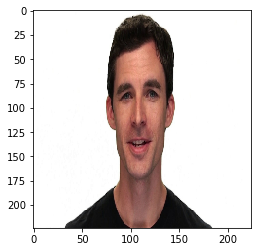

In [22]:
for batch_x, batch_y in dataset:
    print(batch_x.shape, batch_y.shape)
    
    target_class = np.argmax(batch_y[0].numpy())
    print(label_dict[target_class])
    plt.figure()
    plt.imshow(batch_x[0].numpy())
    plt.show()
    
    break

In [30]:
for batch_x, batch_y in valid_dataset:
    print(batch_x.shape, batch_y.shape)
    print(batch_y)
    
    target_class = np.argmax(batch_y[0].numpy())
    print(label_dict[target_class])
    
    plt.figure()
    plt.imshow(batch_x[0].numpy())
    plt.show()
    
    break

(28, 224, 224, 3) (28, 8)
tf.Tensor(
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]], shape=(28, 8), dtype=float32)
happy
